<a href="https://colab.research.google.com/github/jchou3/GAN_MNIST_example/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os
import random

import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils, plot_model
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train = (x_train.astype(np.float32) - 127.5) / 255.0

x_dataset = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_dataset.shape

(60000, 28, 28, 1)

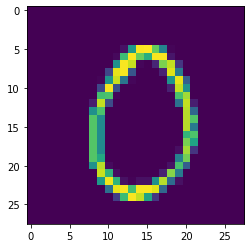

In [ ]:
example = x_dataset[210]
plt.imshow(example.reshape(28, 28))
plt.show()

In [ ]:
batch_size = 32

def create_batch(X_train):
  dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)

  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  return dataset

In [ ]:
#for mnist
latent_dim = 100

generator = keras.models.Sequential()
generator.add(keras.layers.Dense(7 * 7 * 128, input_shape = [latent_dim]))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Reshape([7, 7, 128]))
generator.add(keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding = "same"))
generator.add(keras.layers.LeakyReLU(0.2))
generator.add(keras.layers.Conv2DTranspose(1, (4, 4), (2, 2), padding = "same", activation = "tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        1025      
 ranspose)                                              

In [ ]:
discriminator = keras.models.Sequential()

discriminator.add(keras.layers.Conv2D(64, (5, 5), (2, 2), padding = "same", input_shape = [28, 28, 1]))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Conv2D(128, (5, 5), (2, 2), padding = "same"))
discriminator.add(keras.layers.LeakyReLU(0.2))
discriminator.add(keras.layers.Dropout(0.3))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))

discriminator.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

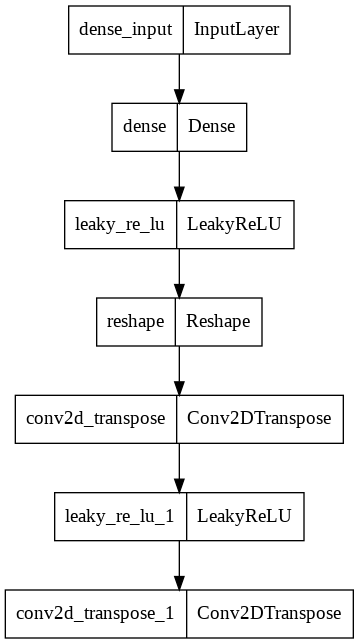

In [ ]:
plot_model(generator, to_file='generator.png')

In [ ]:
discriminator.compile(loss = "binary_crossentropy", optimizer = "adam")

discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])

gan.compile(loss = "binary_crossentropy", optimizer = "adam")
progress = []

In [ ]:
glosses = []
dlosses = []

In [ ]:
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dlosses, label='Discriminitive loss')
    plt.plot(glosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


In [ ]:
def train(generator, discriminator, gan, dataset, latent_dim, epochs, batch_size):
  for epoch in tqdm(range(epochs)):
    print()
    print("Epoch {}/{}".format(epoch + 1, epochs))

    for x in dataset:

      # Creates first set of generated fake images
      noise = tf.random.normal(shape = [batch_size, latent_dim])
      generated_images = generator(noise)


      # training discriminator only
      x_data = tf.concat([generated_images, x], axis = 0)
      y1 = tf.constant(([[0.]] * batch_size) + ([[1.]] * batch_size))
      discriminator.trainable = True


      dloss = discriminator.train_on_batch(x_data, y1)


      noise = tf.random.normal(shape = [batch_size, latent_dim])
      y2 = tf.constant([[1.]] * (batch_size))
      discriminator.trainable = False
      gloss = gan.train_on_batch(noise, y2)

      dlosses.append(dloss)
      glosses.append(gloss)
    
    noise = tf.random.normal(shape = [1, latent_dim])
    progress.append(generator.predict(noise))

    plotLoss(epoch)




  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
1/1 [==============================] - 0s 14ms/step


  1%|          | 1/100 [00:51<1:24:11, 51.03s/it]


Epoch 2/100
1/1 [==============================] - 0s 14ms/step


  2%|▏         | 2/100 [01:31<1:13:30, 45.01s/it]


Epoch 3/100
1/1 [==============================] - 0s 15ms/step


  3%|▎         | 3/100 [02:16<1:12:15, 44.69s/it]


Epoch 4/100
1/1 [==============================] - 0s 14ms/step


  4%|▍         | 4/100 [03:00<1:11:27, 44.66s/it]


Epoch 5/100
1/1 [==============================] - 0s 14ms/step


  5%|▌         | 5/100 [03:43<1:09:24, 43.83s/it]


Epoch 6/100
1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [04:27<1:09:12, 44.17s/it]


Epoch 7/100
1/1 [==============================] - 0s 14ms/step


  7%|▋         | 7/100 [05:13<1:09:10, 44.63s/it]


Epoch 8/100
1/1 [==============================] - 0s 23ms/step


  8%|▊         | 8/100 [05:57<1:08:01, 44.37s/it]


Epoch 9/100
1/1 [==============================] - 0s 14ms/step


  9%|▉         | 9/100 [06:41<1:07:11, 44.31s/it]


Epoch 10/100
1/1 [==============================] - 0s 14ms/step


 10%|█         | 10/100 [07:26<1:06:36, 44.41s/it]


Epoch 11/100
1/1 [==============================] - 0s 14ms/step


 11%|█         | 11/100 [08:08<1:04:46, 43.67s/it]


Epoch 12/100
1/1 [==============================] - 0s 14ms/step


 12%|█▏        | 12/100 [08:50<1:03:20, 43.19s/it]


Epoch 13/100
1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 13/100 [09:33<1:02:48, 43.31s/it]


Epoch 14/100
1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 14/100 [10:16<1:01:51, 43.16s/it]


Epoch 15/100
1/1 [==============================] - 0s 13ms/step


 15%|█▌        | 15/100 [10:57<1:00:04, 42.40s/it]


Epoch 16/100
1/1 [==============================] - 0s 14ms/step


 16%|█▌        | 16/100 [11:39<59:12, 42.29s/it]  


Epoch 17/100
1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 17/100 [12:19<57:41, 41.71s/it]


Epoch 18/100
1/1 [==============================] - 0s 13ms/step


 18%|█▊        | 18/100 [13:00<56:47, 41.55s/it]


Epoch 19/100
1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 19/100 [14:22<1:12:29, 53.69s/it]


Epoch 20/100
1/1 [==============================] - 0s 13ms/step


 20%|██        | 20/100 [15:04<1:06:58, 50.23s/it]


Epoch 21/100
1/1 [==============================] - 0s 15ms/step


<ipython-input-11-f6a295520534>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 8))
 21%|██        | 21/100 [16:26<1:18:41, 59.76s/it]


Epoch 22/100
1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 22/100 [17:09<1:10:46, 54.44s/it]


Epoch 23/100
1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 23/100 [17:51<1:05:16, 50.86s/it]


Epoch 24/100
1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [18:33<1:00:55, 48.10s/it]


Epoch 25/100
1/1 [==============================] - 0s 14ms/step


 25%|██▌       | 25/100 [19:15<57:59, 46.40s/it]  


Epoch 26/100
1/1 [==============================] - 0s 13ms/step


 26%|██▌       | 26/100 [19:57<55:42, 45.17s/it]


Epoch 27/100
1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 27/100 [20:39<53:30, 43.98s/it]


Epoch 28/100
1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 28/100 [21:22<52:26, 43.71s/it]


Epoch 29/100
1/1 [==============================] - 0s 13ms/step


 29%|██▉       | 29/100 [22:01<50:20, 42.54s/it]


Epoch 30/100
1/1 [==============================] - 0s 15ms/step


 30%|███       | 30/100 [22:43<49:22, 42.32s/it]


Epoch 31/100
1/1 [==============================] - 0s 13ms/step


 31%|███       | 31/100 [23:25<48:21, 42.05s/it]


Epoch 32/100
1/1 [==============================] - 0s 13ms/step


 32%|███▏      | 32/100 [24:05<47:10, 41.62s/it]


Epoch 33/100
1/1 [==============================] - 0s 13ms/step


 33%|███▎      | 33/100 [24:49<47:19, 42.38s/it]


Epoch 34/100
1/1 [==============================] - 0s 13ms/step


 34%|███▍      | 34/100 [25:29<45:48, 41.64s/it]


Epoch 35/100
1/1 [==============================] - 0s 14ms/step


 35%|███▌      | 35/100 [26:12<45:27, 41.97s/it]


Epoch 36/100
1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 36/100 [26:55<45:09, 42.33s/it]


Epoch 37/100
1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 37/100 [27:39<44:57, 42.81s/it]


Epoch 38/100
1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 38/100 [28:22<44:08, 42.72s/it]


Epoch 39/100
1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 39/100 [29:05<43:27, 42.74s/it]


Epoch 40/100
1/1 [==============================] - 0s 13ms/step


 40%|████      | 40/100 [29:47<42:45, 42.77s/it]


Epoch 41/100
1/1 [==============================] - 0s 16ms/step


 41%|████      | 41/100 [30:29<41:44, 42.44s/it]


Epoch 42/100
1/1 [==============================] - 0s 13ms/step


 42%|████▏     | 42/100 [31:10<40:29, 41.89s/it]


Epoch 43/100
1/1 [==============================] - 0s 14ms/step


 43%|████▎     | 43/100 [31:54<40:26, 42.57s/it]


Epoch 44/100
1/1 [==============================] - 0s 13ms/step


 44%|████▍     | 44/100 [32:37<39:49, 42.66s/it]


Epoch 45/100
1/1 [==============================] - 0s 13ms/step


 45%|████▌     | 45/100 [33:20<39:20, 42.92s/it]


Epoch 46/100
1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 46/100 [34:42<49:10, 54.64s/it]


Epoch 47/100
1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 47/100 [35:24<44:45, 50.67s/it]


Epoch 48/100
1/1 [==============================] - 0s 13ms/step


 48%|████▊     | 48/100 [36:05<41:26, 47.82s/it]


Epoch 49/100
1/1 [==============================] - 0s 13ms/step


 49%|████▉     | 49/100 [36:48<39:35, 46.57s/it]


Epoch 50/100
1/1 [==============================] - 0s 13ms/step


 50%|█████     | 50/100 [37:29<37:16, 44.73s/it]


Epoch 51/100
1/1 [==============================] - 0s 13ms/step


 51%|█████     | 51/100 [38:11<35:48, 43.85s/it]


Epoch 52/100
1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [38:53<34:48, 43.50s/it]


Epoch 53/100
1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 53/100 [40:15<43:07, 55.05s/it]


Epoch 54/100
1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 54/100 [40:56<38:59, 50.86s/it]


Epoch 55/100
1/1 [==============================] - 0s 14ms/step


 55%|█████▌    | 55/100 [41:40<36:24, 48.55s/it]


Epoch 56/100
1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 56/100 [42:22<34:15, 46.72s/it]


Epoch 57/100
1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 57/100 [43:44<41:03, 57.30s/it]


Epoch 58/100
1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [44:27<37:08, 53.06s/it]


Epoch 59/100
1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 59/100 [45:49<42:11, 61.74s/it]


Epoch 60/100
1/1 [==============================] - 0s 15ms/step


 60%|██████    | 60/100 [46:34<37:40, 56.51s/it]


Epoch 61/100
1/1 [==============================] - 0s 20ms/step


 61%|██████    | 61/100 [47:17<34:17, 52.75s/it]


Epoch 62/100
1/1 [==============================] - 0s 13ms/step


 62%|██████▏   | 62/100 [47:59<31:21, 49.52s/it]


Epoch 63/100
1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 63/100 [48:42<29:10, 47.30s/it]


Epoch 64/100
1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 64/100 [49:23<27:22, 45.62s/it]


Epoch 65/100
1/1 [==============================] - 0s 13ms/step


 65%|██████▌   | 65/100 [50:04<25:49, 44.28s/it]


Epoch 66/100
1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [50:47<24:45, 43.68s/it]


Epoch 67/100
1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 67/100 [51:28<23:36, 42.93s/it]


Epoch 68/100
1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 68/100 [52:08<22:28, 42.14s/it]


Epoch 69/100
1/1 [==============================] - 0s 14ms/step


 69%|██████▉   | 69/100 [52:50<21:40, 41.96s/it]


Epoch 70/100
1/1 [==============================] - 0s 13ms/step


 70%|███████   | 70/100 [53:33<21:06, 42.23s/it]


Epoch 71/100
1/1 [==============================] - 0s 13ms/step


 71%|███████   | 71/100 [54:14<20:21, 42.12s/it]


Epoch 72/100
1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [54:56<19:34, 41.94s/it]


Epoch 73/100
1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 73/100 [55:38<18:52, 41.95s/it]


Epoch 74/100
1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [56:19<18:05, 41.74s/it]


Epoch 75/100
1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 75/100 [57:02<17:34, 42.16s/it]


Epoch 76/100
1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [57:45<16:53, 42.23s/it]


Epoch 77/100
1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 77/100 [58:26<16:02, 41.84s/it]


Epoch 78/100
1/1 [==============================] - 0s 14ms/step


 78%|███████▊  | 78/100 [59:08<15:24, 42.01s/it]


Epoch 79/100
1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 79/100 [59:49<14:36, 41.73s/it]


Epoch 80/100
1/1 [==============================] - 0s 13ms/step


 80%|████████  | 80/100 [1:00:30<13:48, 41.45s/it]


Epoch 81/100
1/1 [==============================] - 0s 14ms/step


 81%|████████  | 81/100 [1:01:11<13:04, 41.28s/it]


Epoch 82/100
1/1 [==============================] - 0s 13ms/step


 82%|████████▏ | 82/100 [1:01:52<12:23, 41.31s/it]


Epoch 83/100
1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 83/100 [1:02:34<11:45, 41.52s/it]


Epoch 84/100
1/1 [==============================] - 0s 14ms/step


 84%|████████▍ | 84/100 [1:03:16<11:05, 41.57s/it]


Epoch 85/100
1/1 [==============================] - 0s 14ms/step


 85%|████████▌ | 85/100 [1:03:58<10:25, 41.71s/it]


Epoch 86/100
1/1 [==============================] - 0s 13ms/step


 86%|████████▌ | 86/100 [1:04:41<09:49, 42.12s/it]


Epoch 87/100
1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 87/100 [1:05:22<09:03, 41.78s/it]


Epoch 88/100
1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [1:06:04<08:22, 41.90s/it]


Epoch 89/100
1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 89/100 [1:06:46<07:41, 41.98s/it]


Epoch 90/100
1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 90/100 [1:07:29<07:01, 42.12s/it]


Epoch 91/100
1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 91/100 [1:08:11<06:19, 42.22s/it]


Epoch 92/100
1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 92/100 [1:09:33<07:13, 54.15s/it]


Epoch 93/100
1/1 [==============================] - 0s 13ms/step


 93%|█████████▎| 93/100 [1:10:16<05:54, 50.70s/it]


Epoch 94/100
1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 94/100 [1:10:55<04:43, 47.23s/it]


Epoch 95/100
1/1 [==============================] - 0s 13ms/step


 95%|█████████▌| 95/100 [1:11:35<03:44, 44.96s/it]


Epoch 96/100
1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [1:12:14<02:52, 43.15s/it]


Epoch 97/100
1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 97/100 [1:12:53<02:06, 42.15s/it]


Epoch 98/100
1/1 [==============================] - 0s 14ms/step


 98%|█████████▊| 98/100 [1:13:33<01:22, 41.26s/it]


Epoch 99/100
1/1 [==============================] - 0s 14ms/step


 99%|█████████▉| 99/100 [1:14:12<00:40, 40.65s/it]


Epoch 100/100
1/1 [==============================] - 0s 19ms/step


100%|██████████| 100/100 [1:14:51<00:00, 44.91s/it]


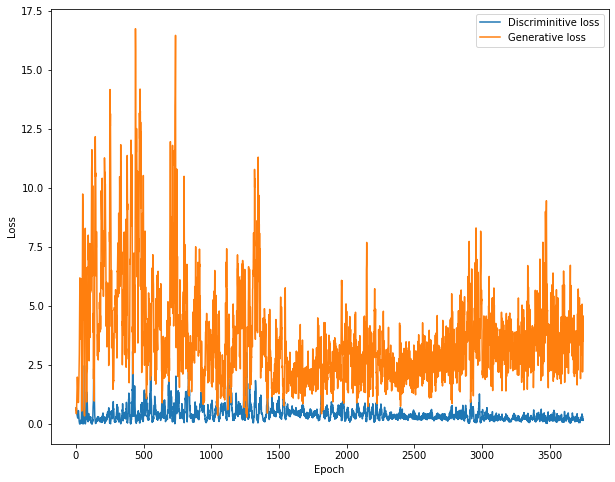

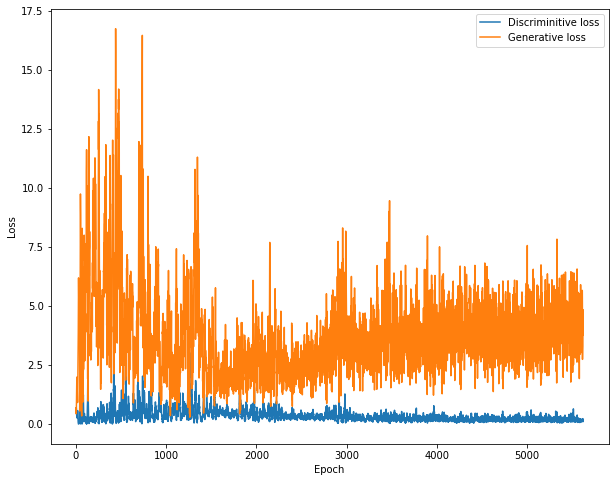

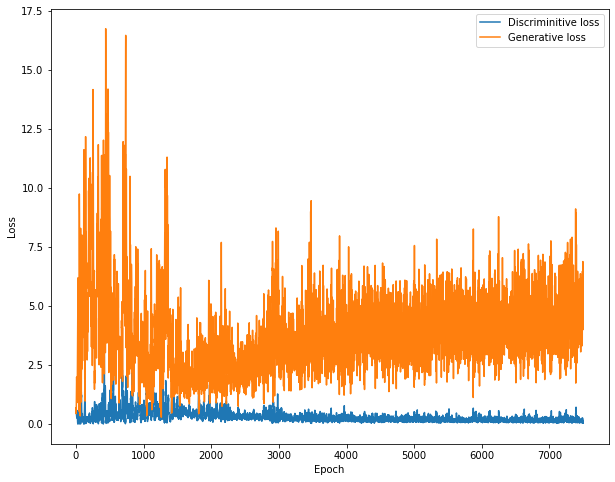

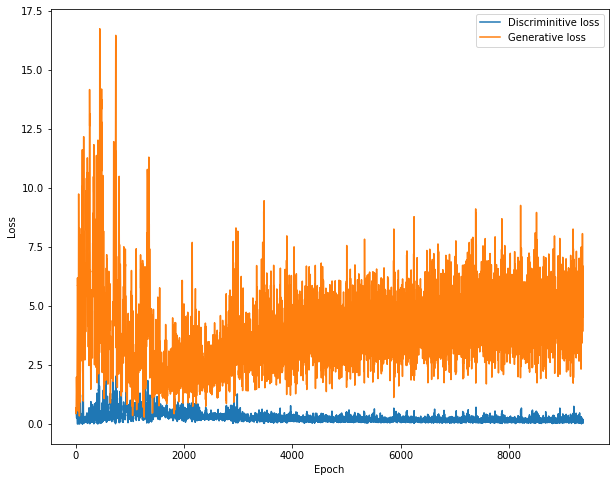

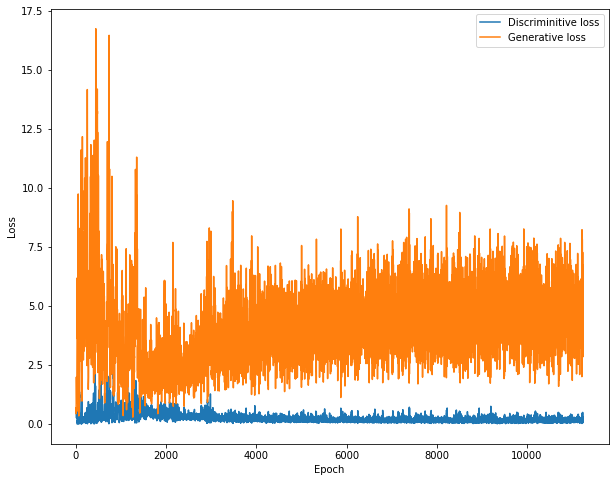

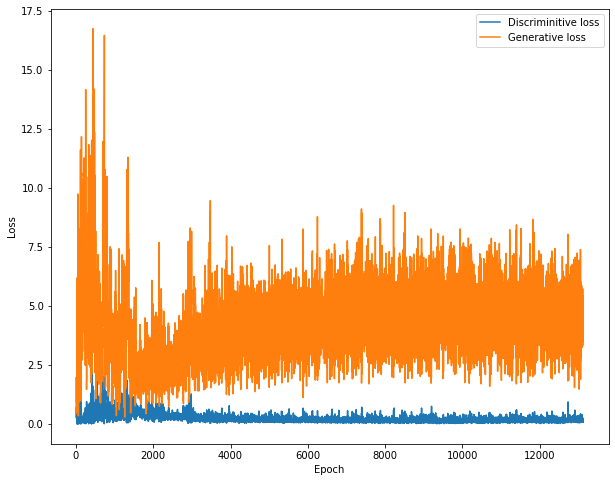

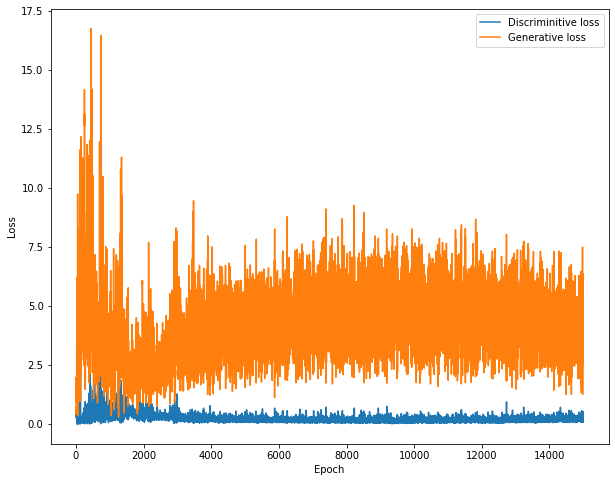

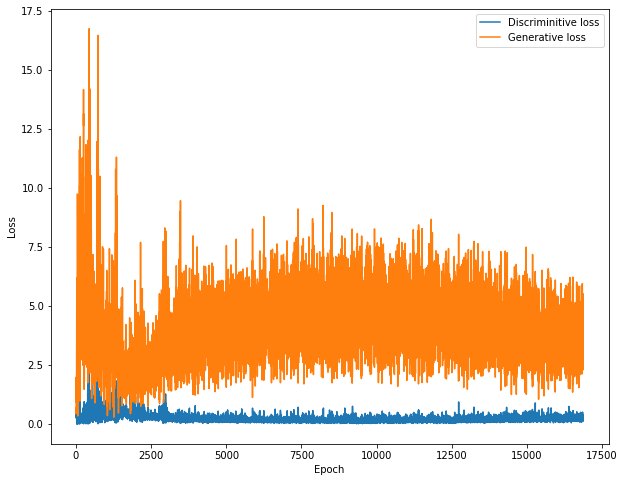

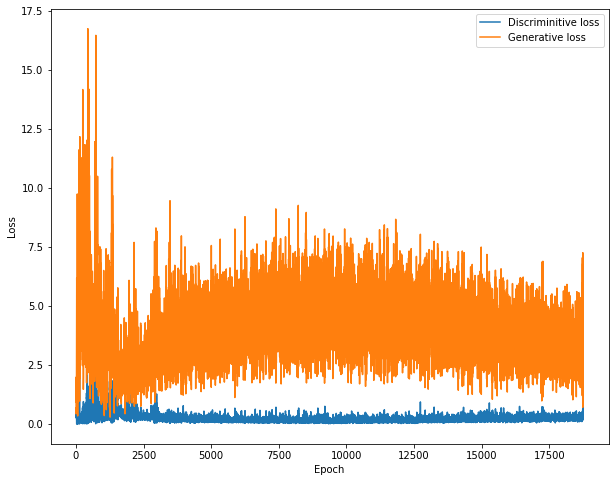

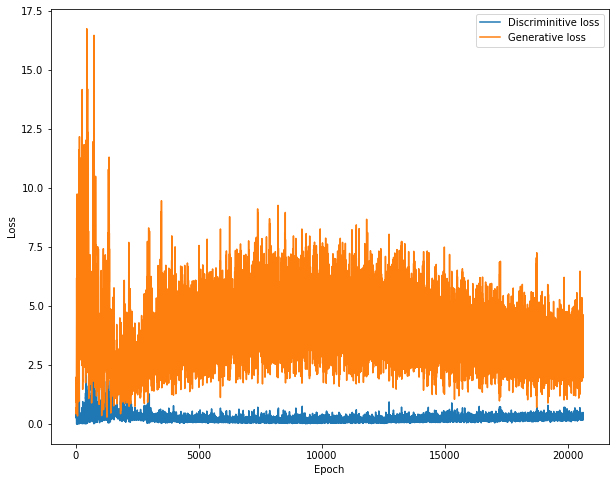

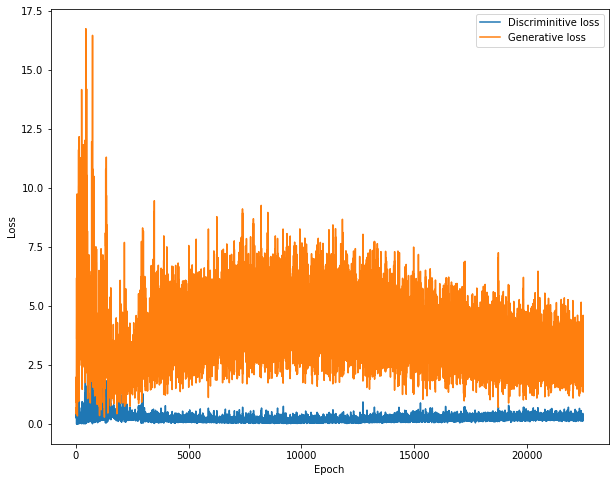

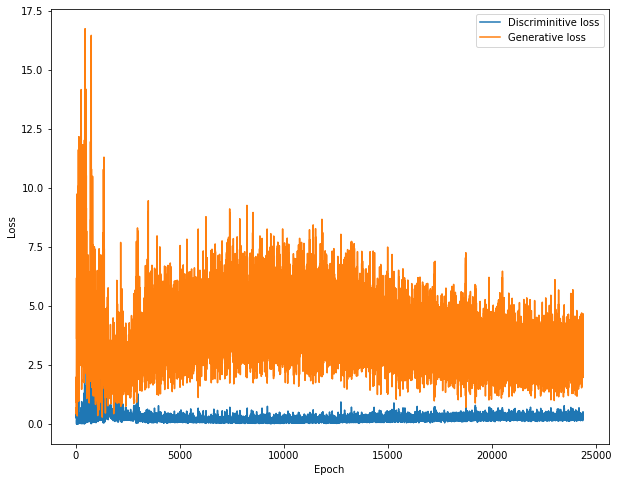

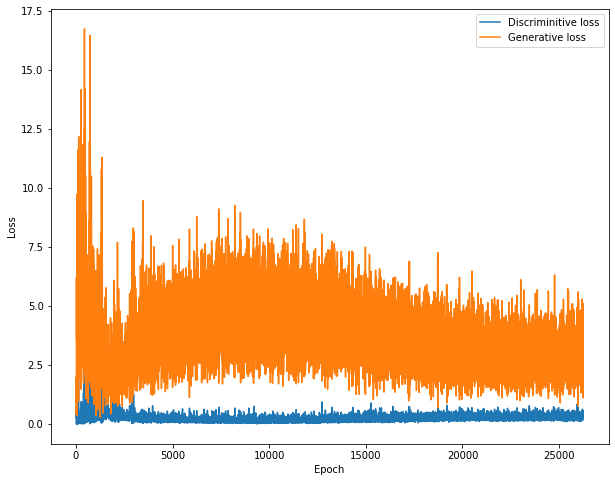

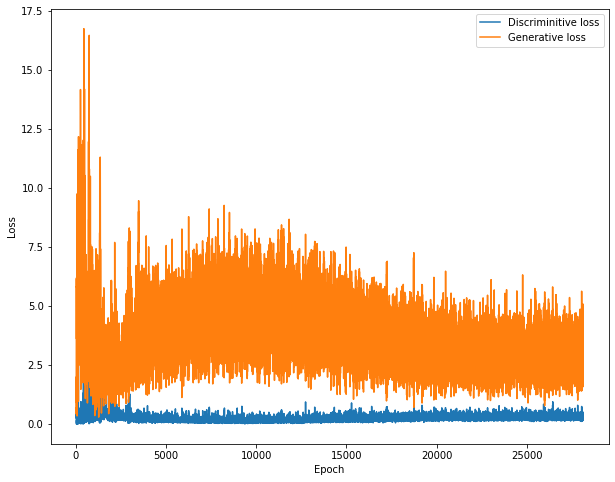

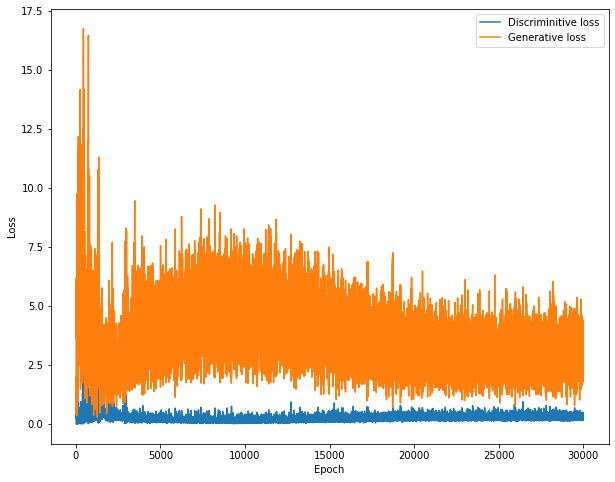

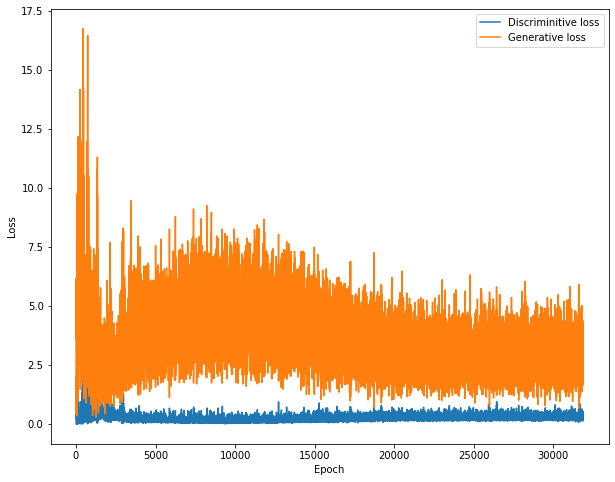

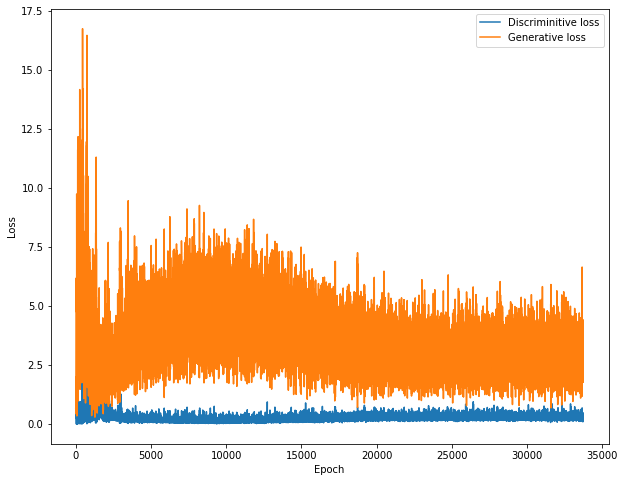

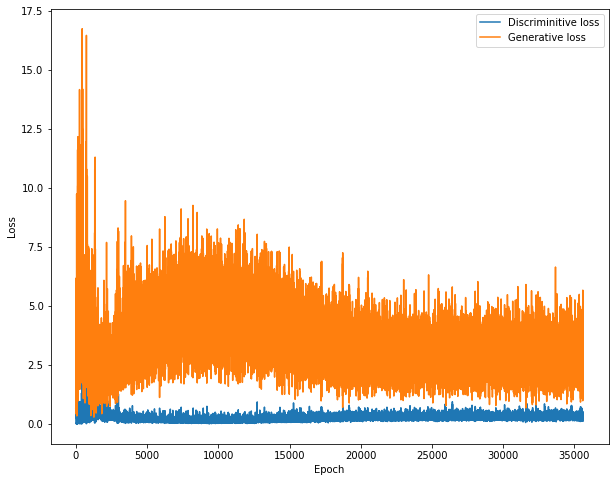

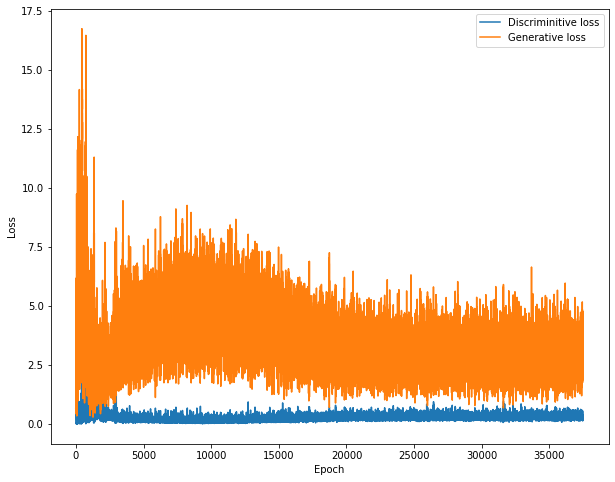

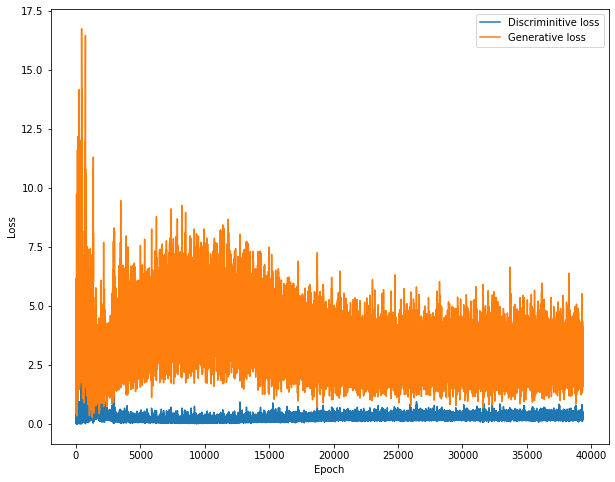

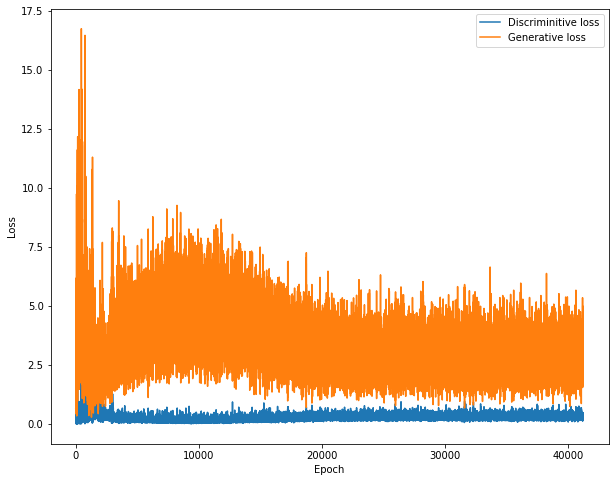

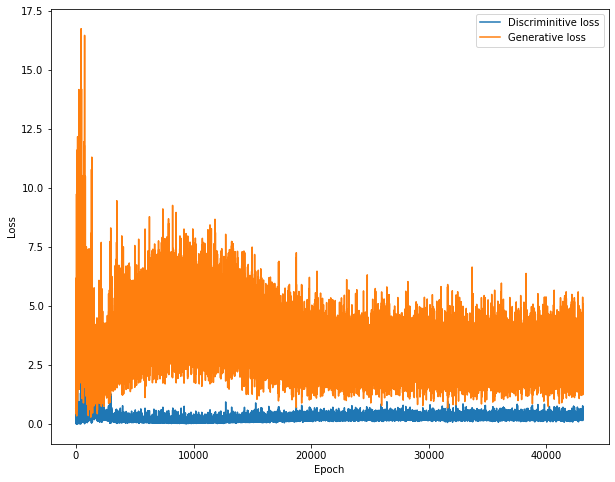

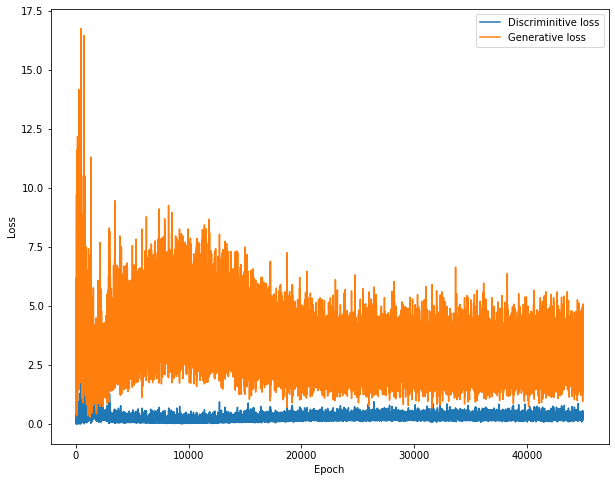

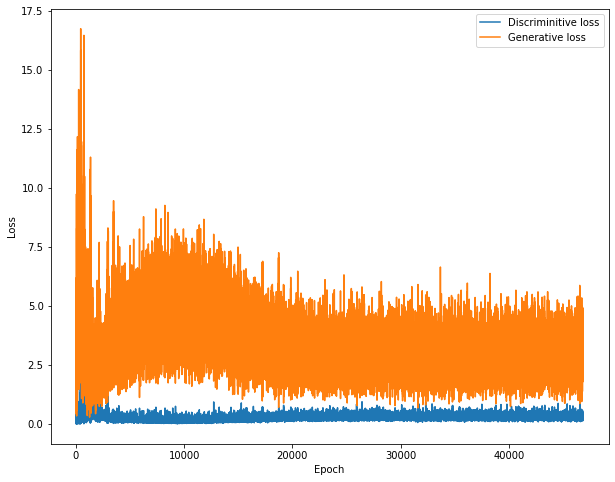

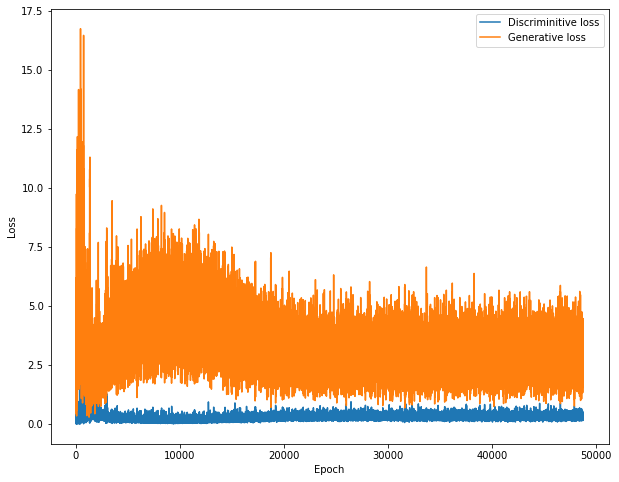

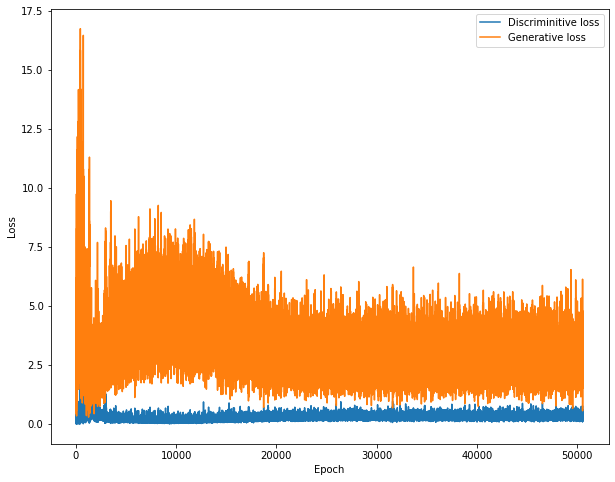

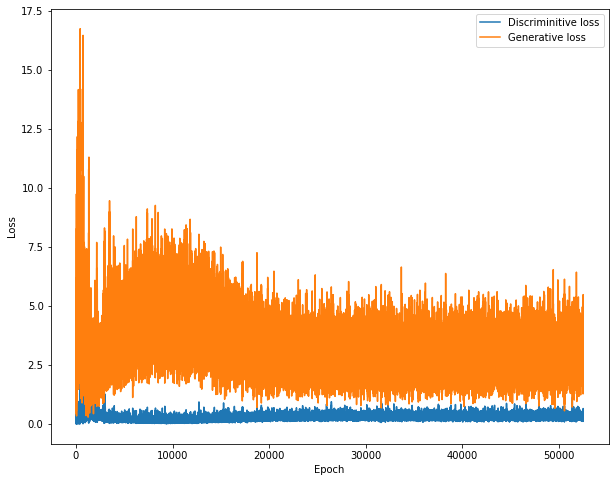

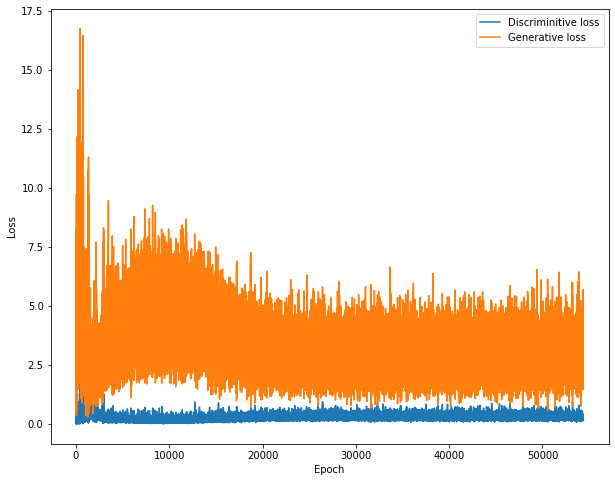

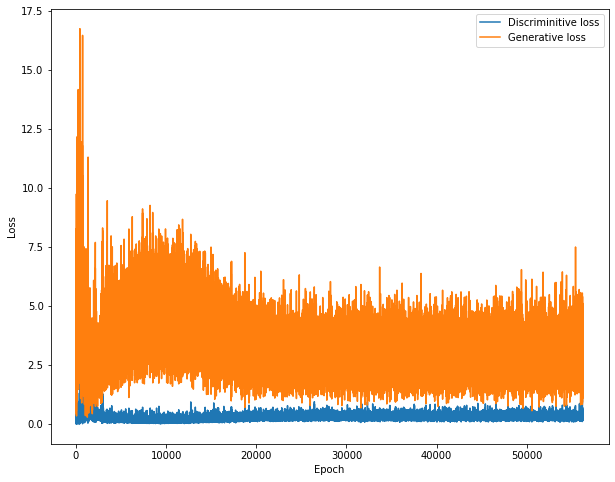

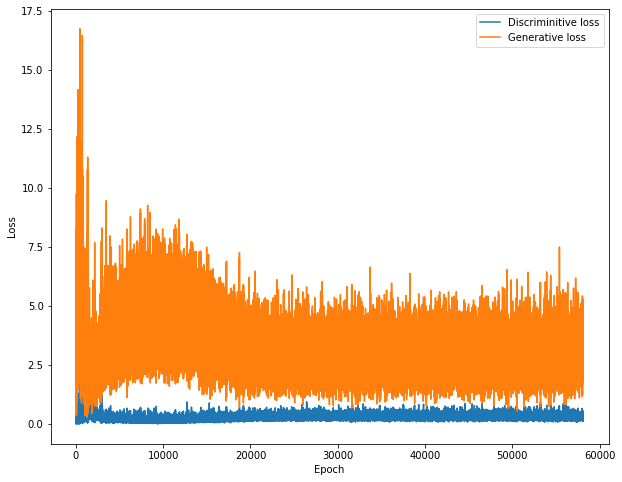

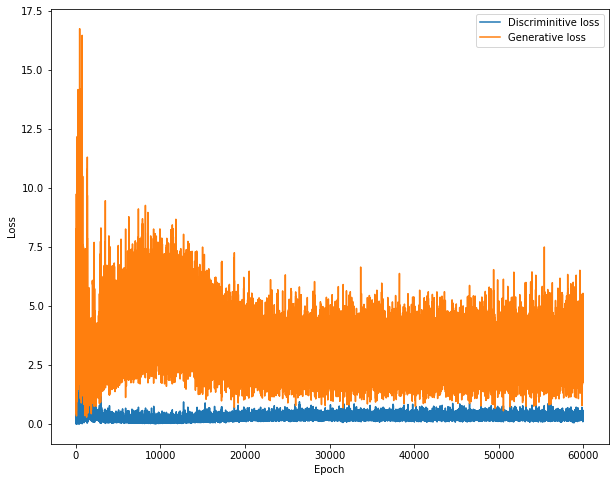

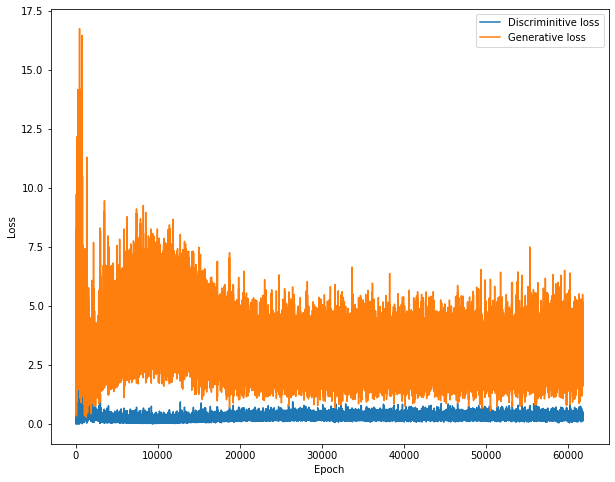

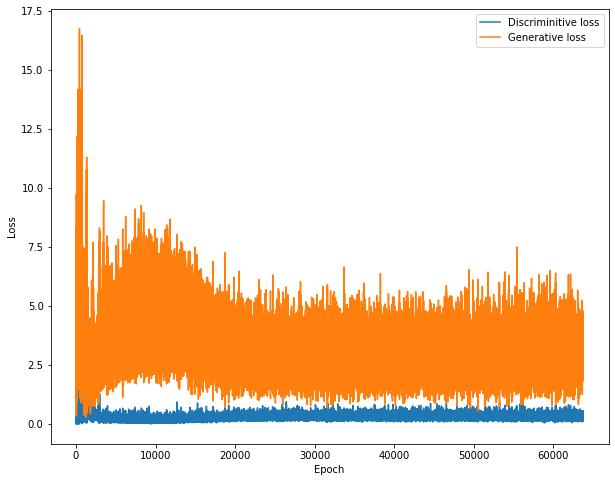

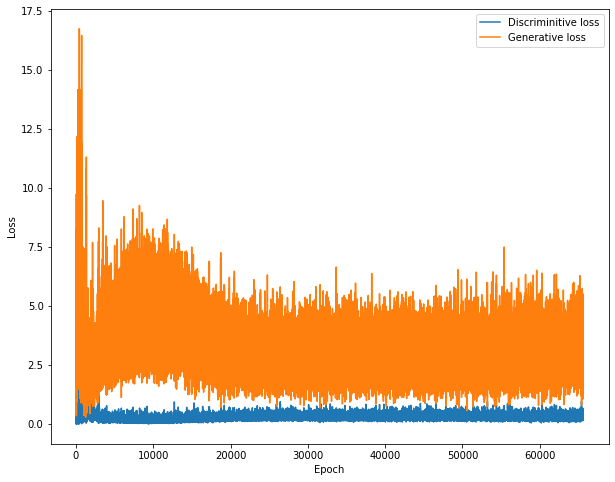

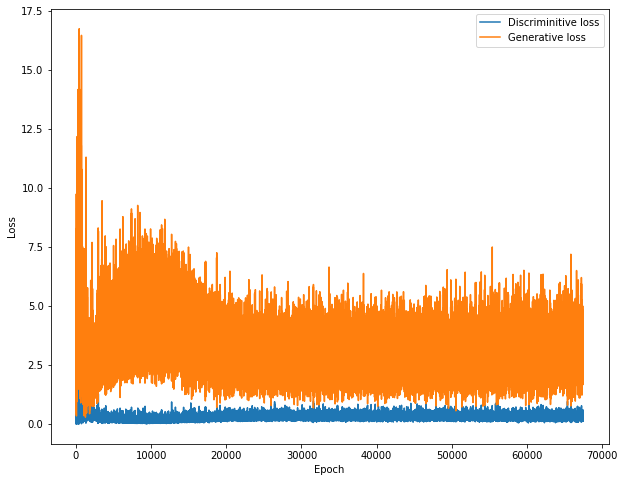

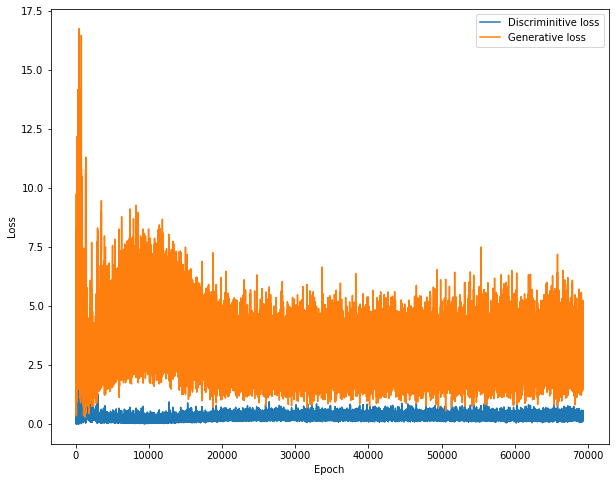

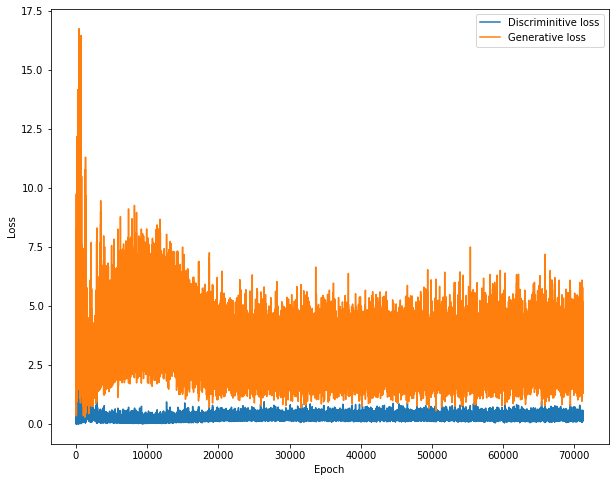

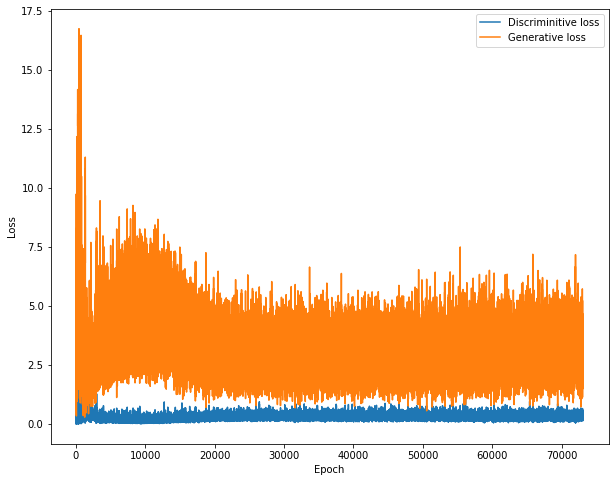

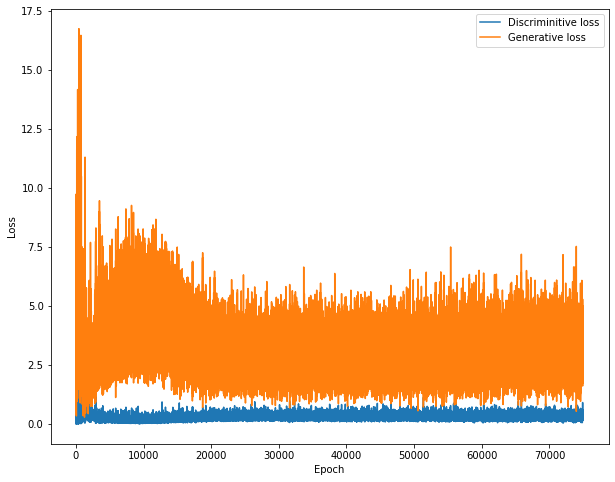

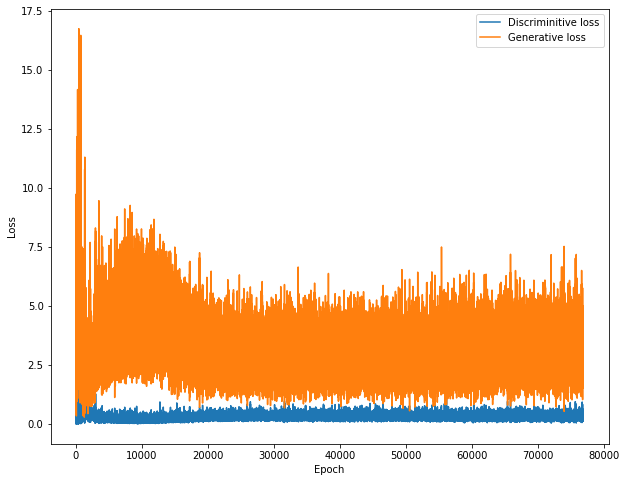

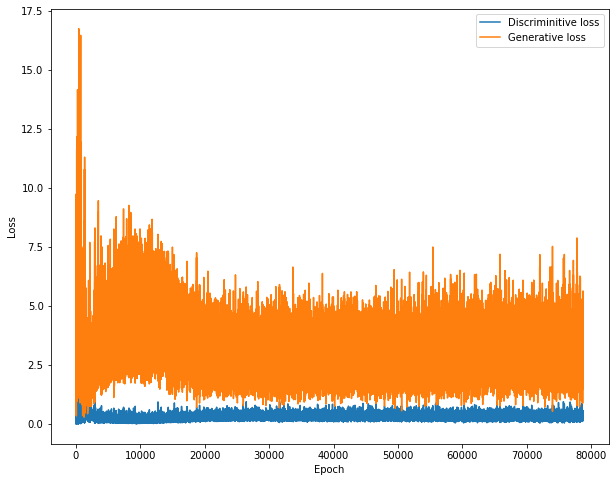

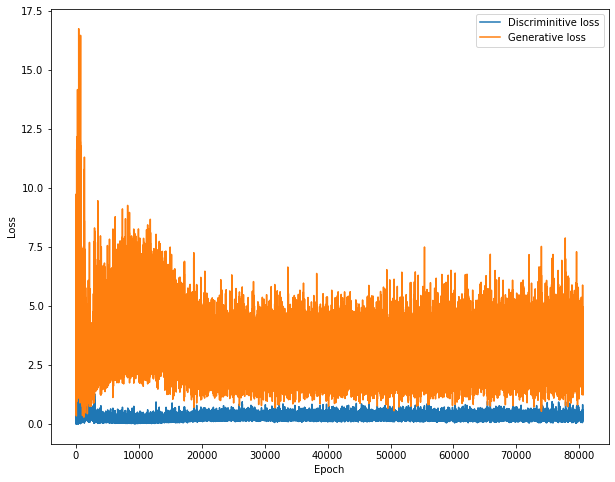

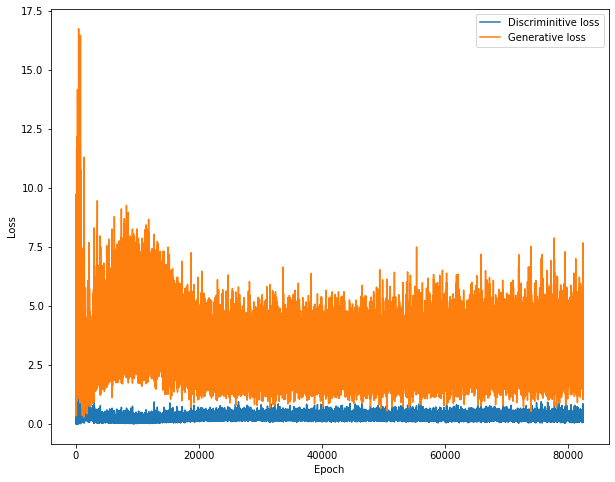

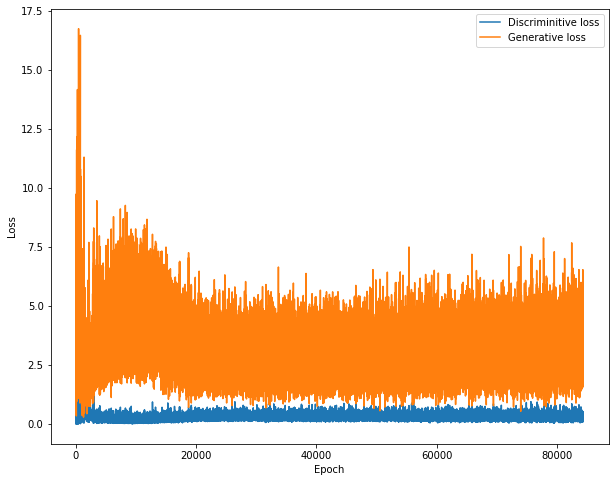

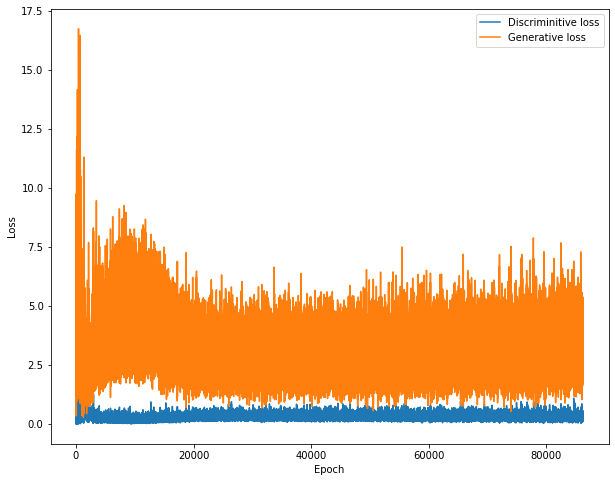

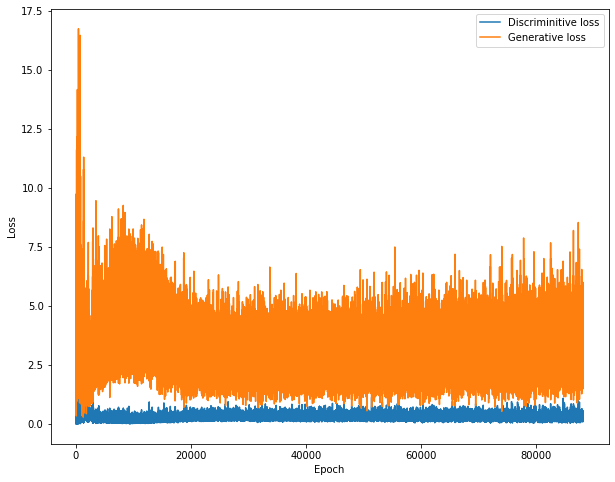

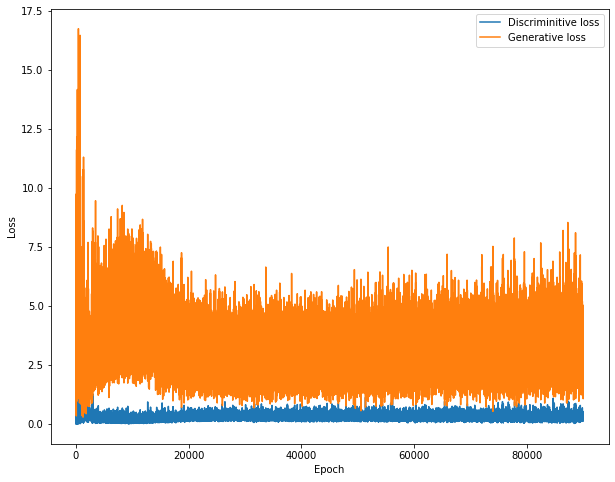

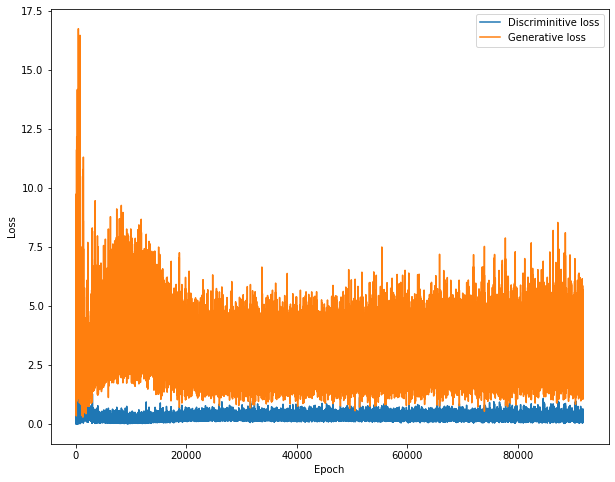

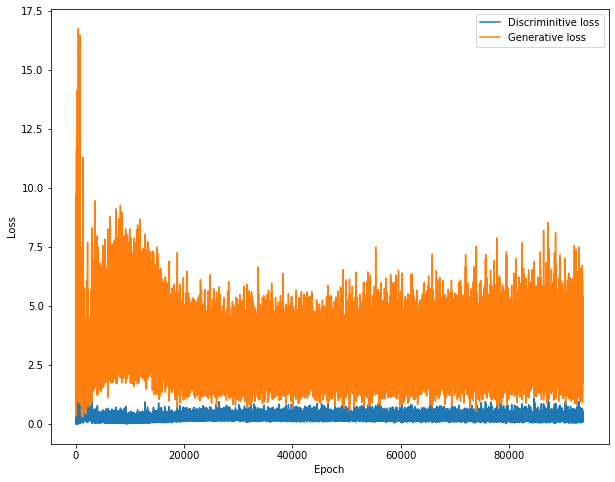

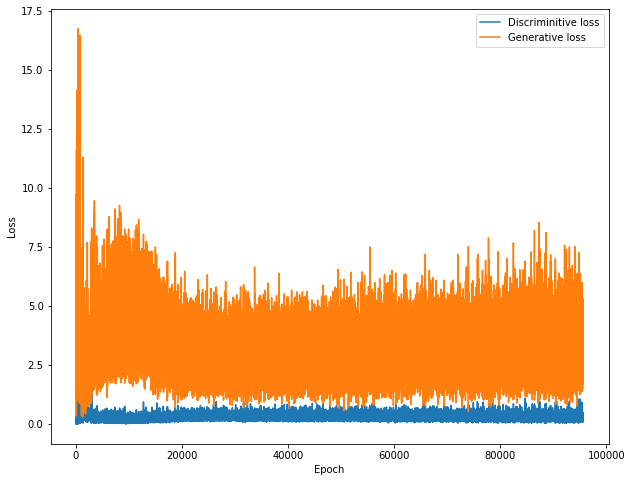

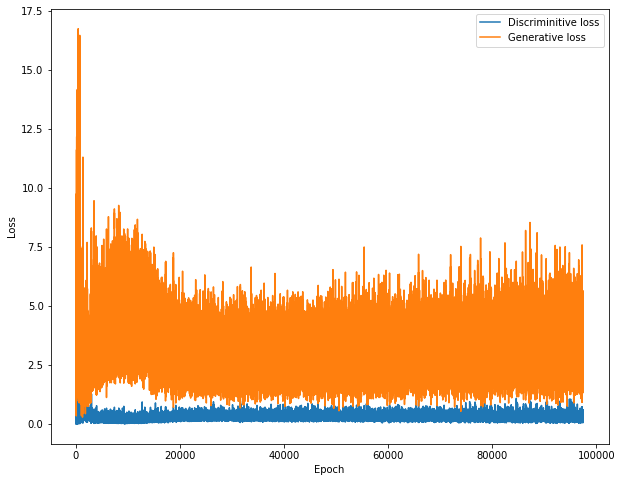

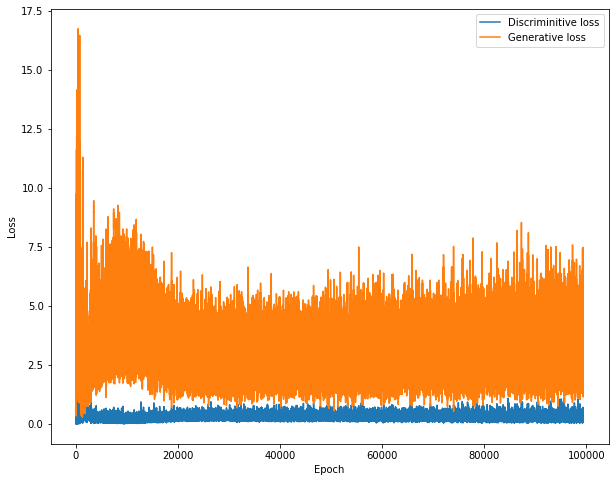

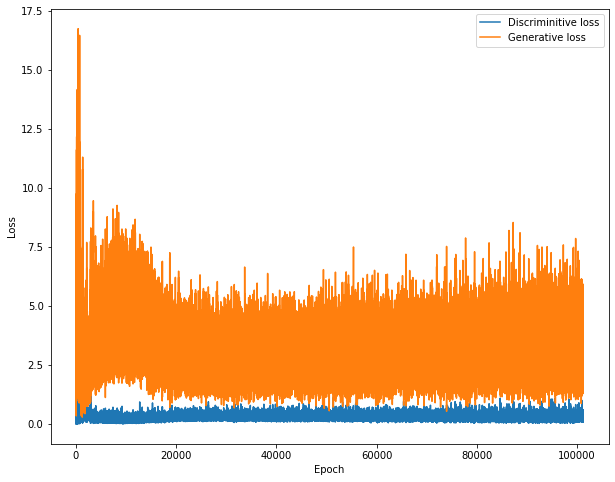

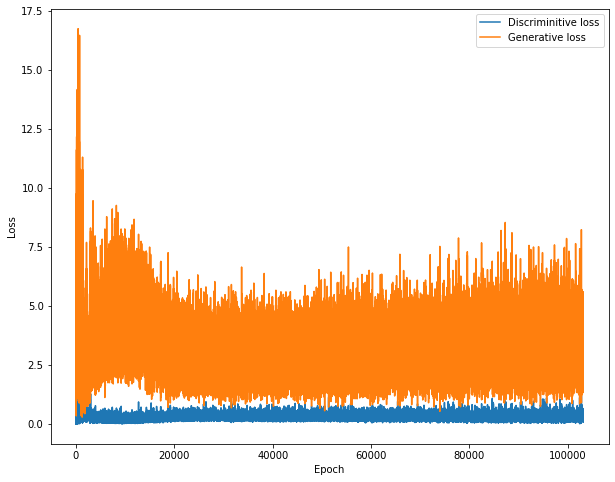

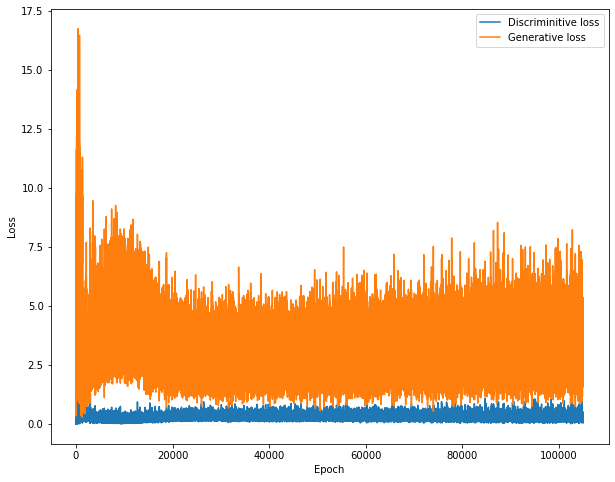

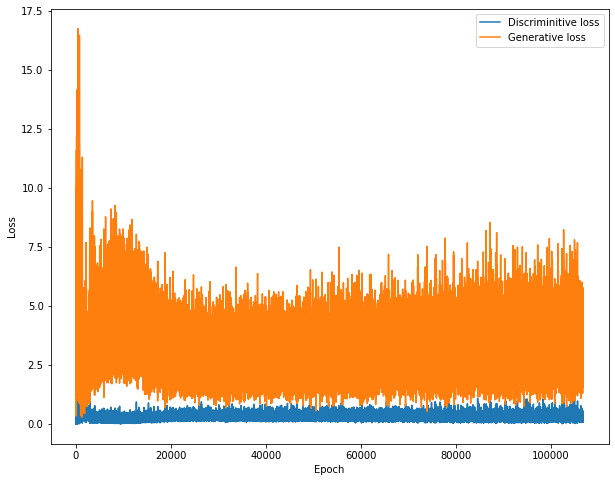

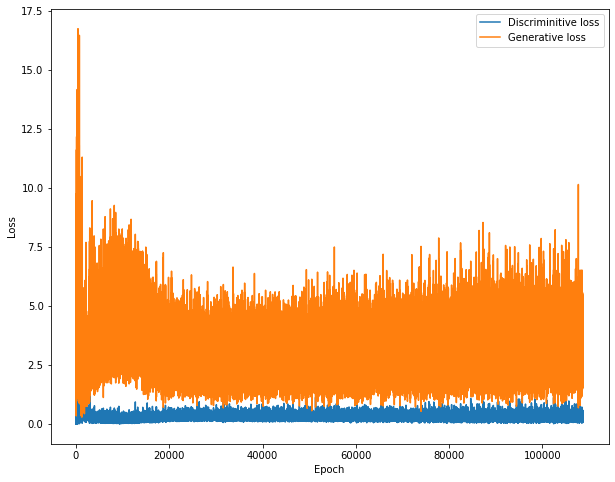

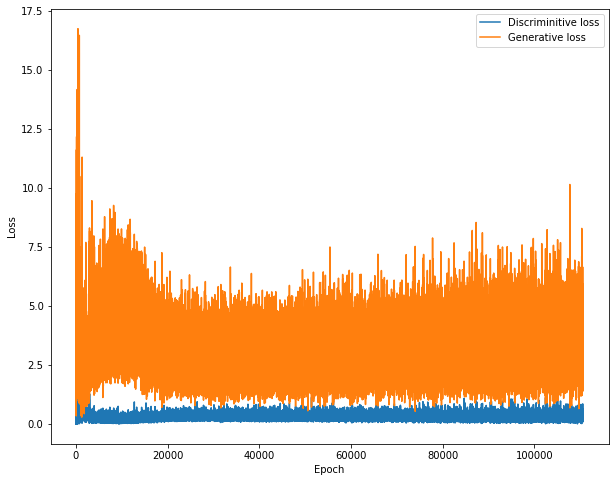

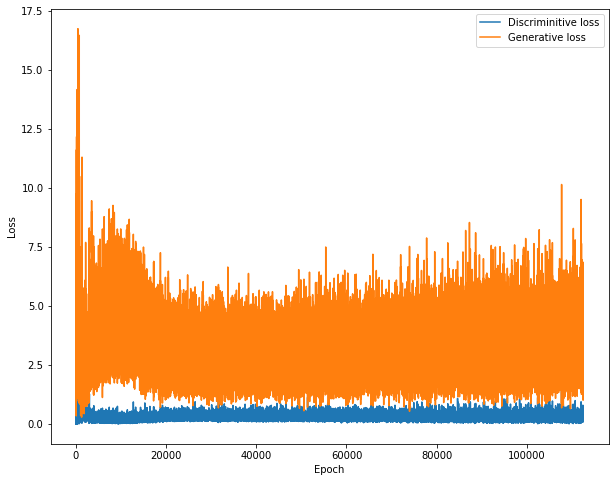

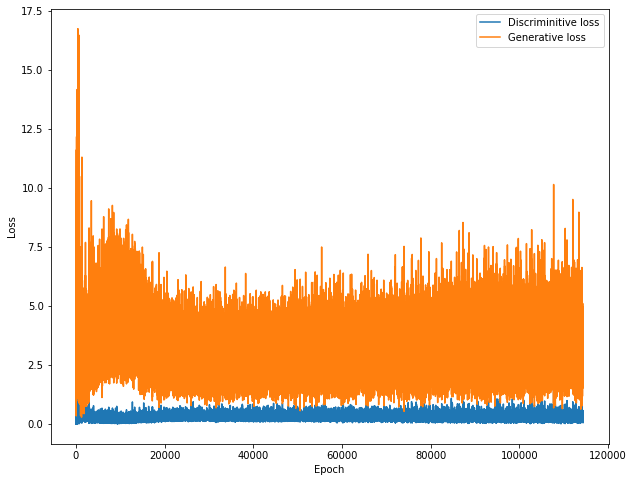

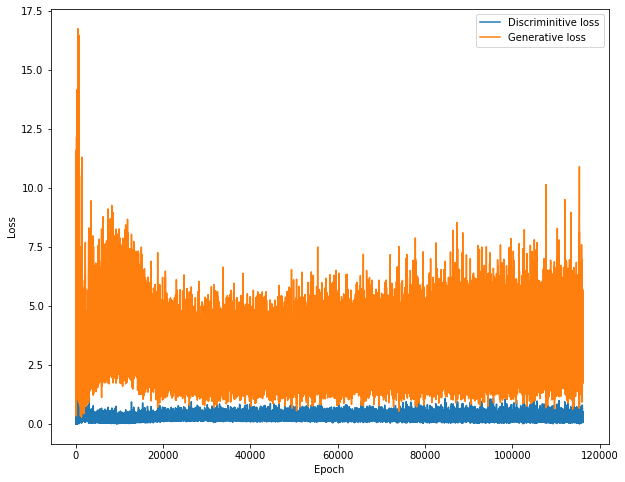

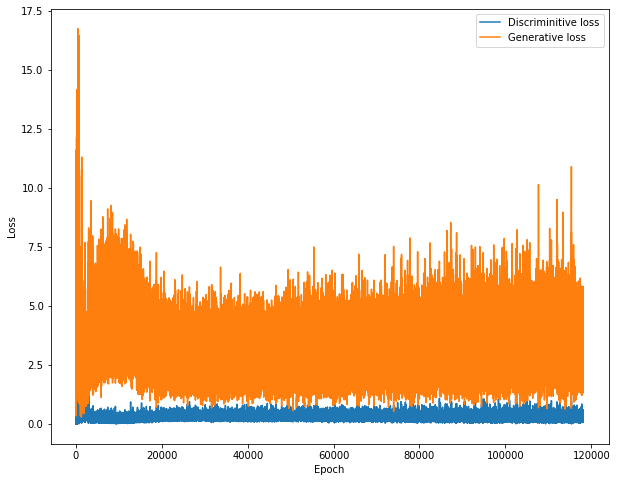

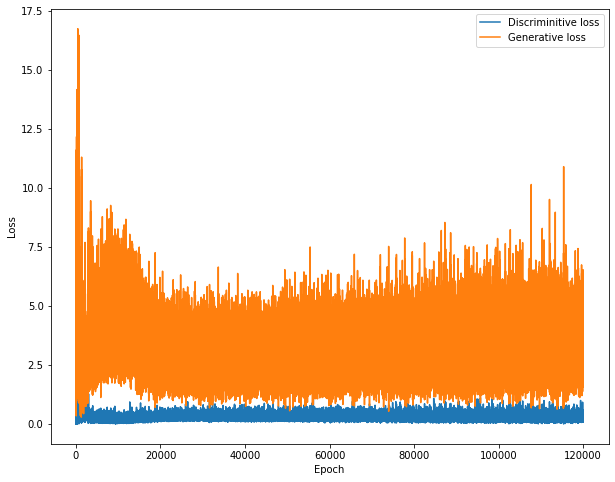

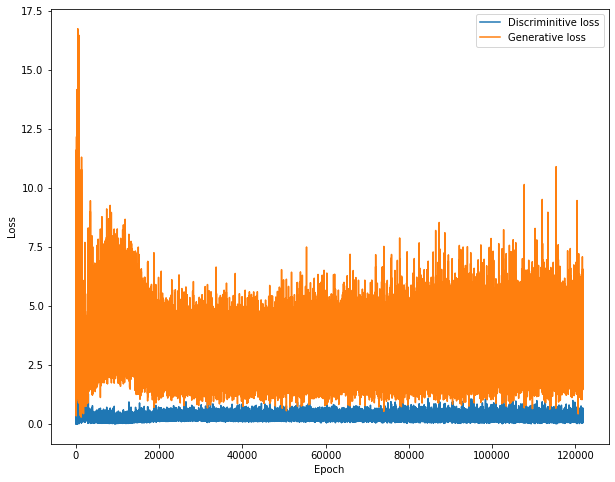

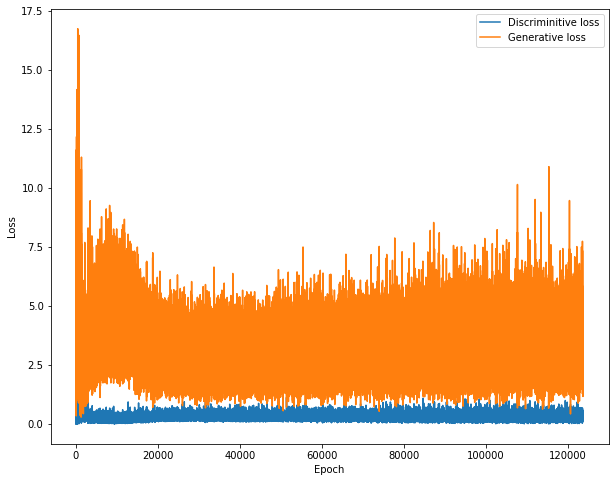

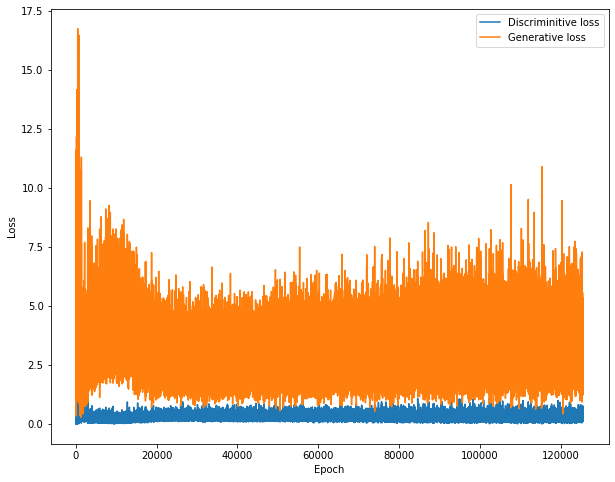

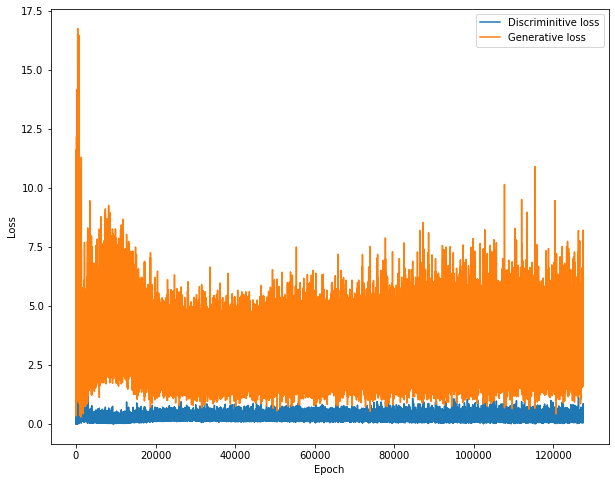

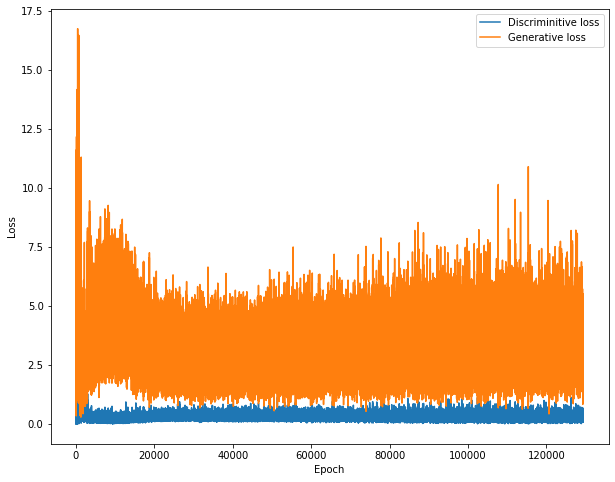

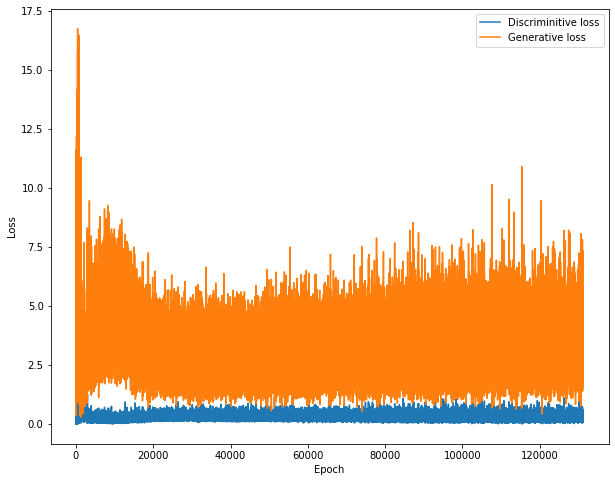

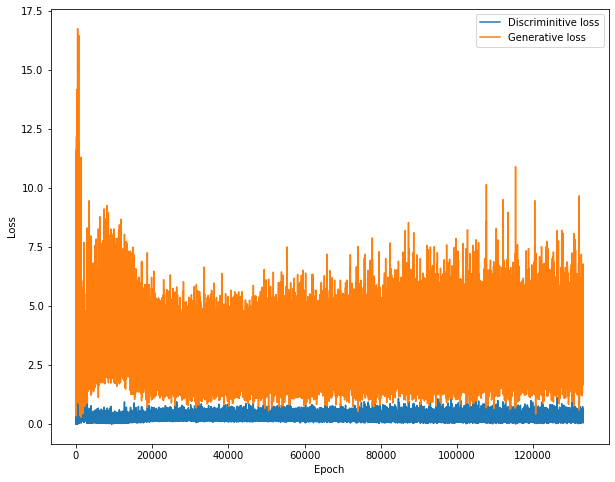

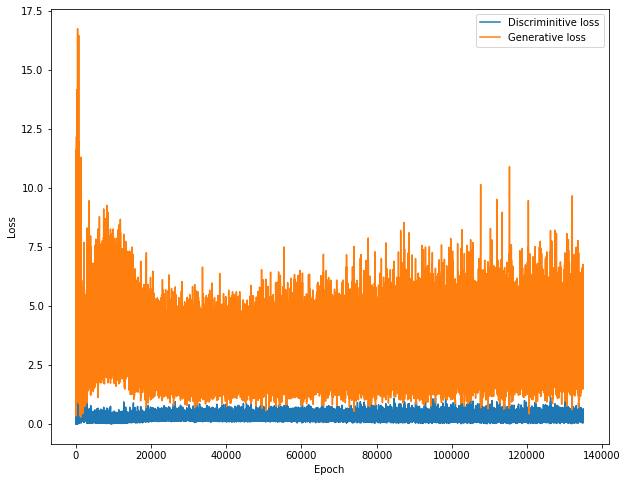

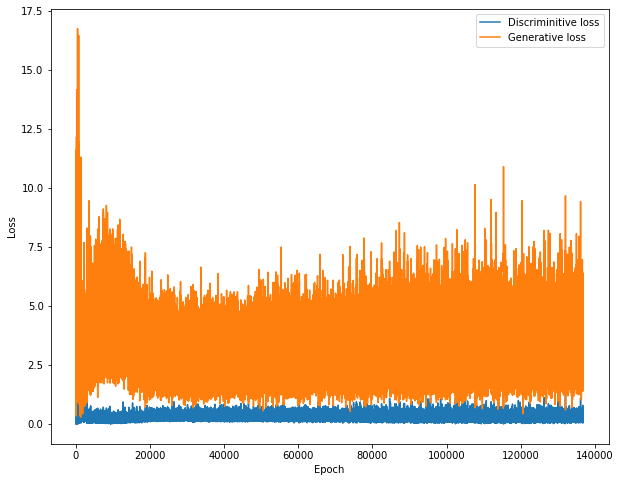

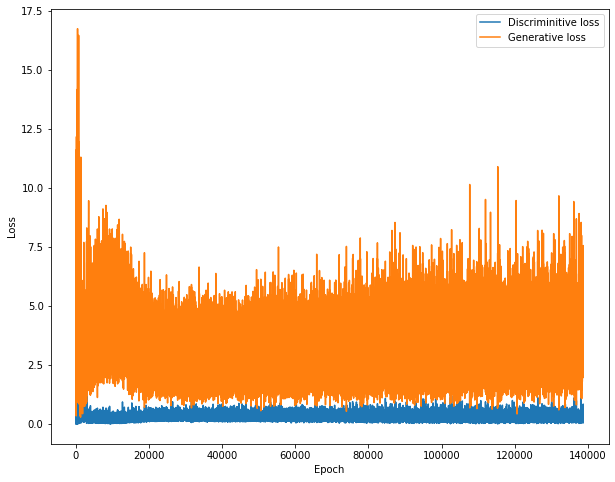

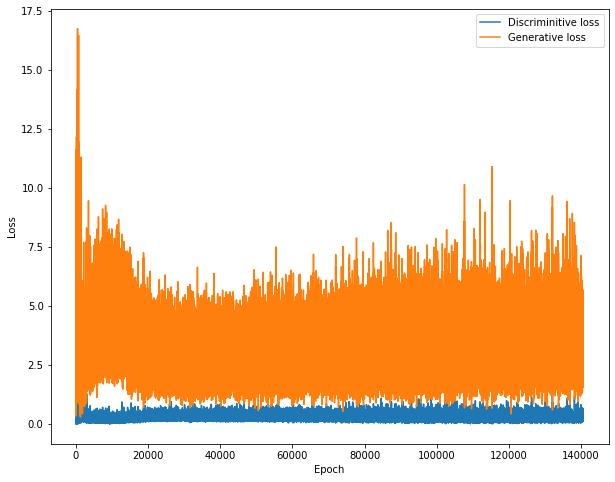

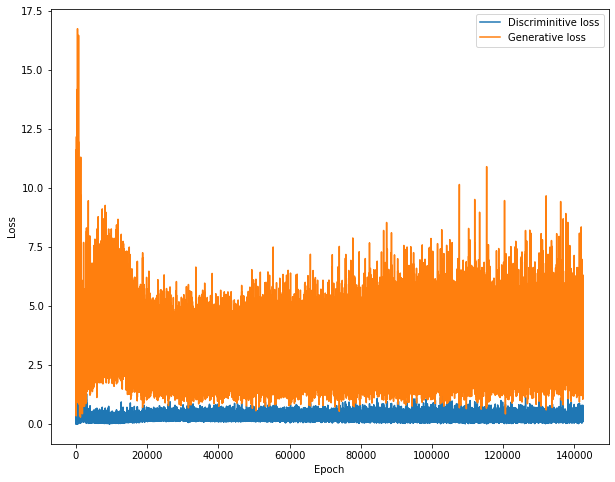

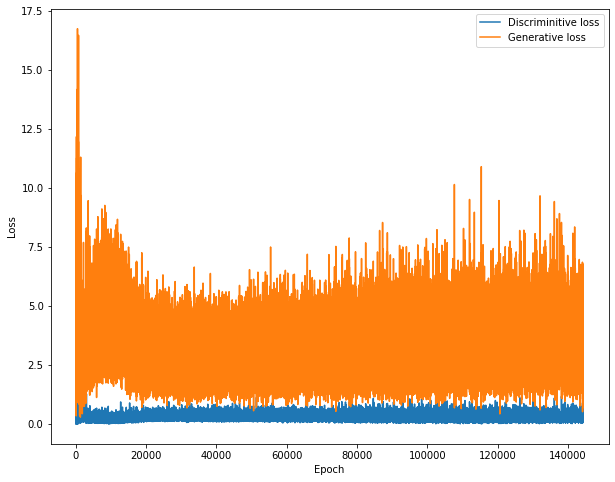

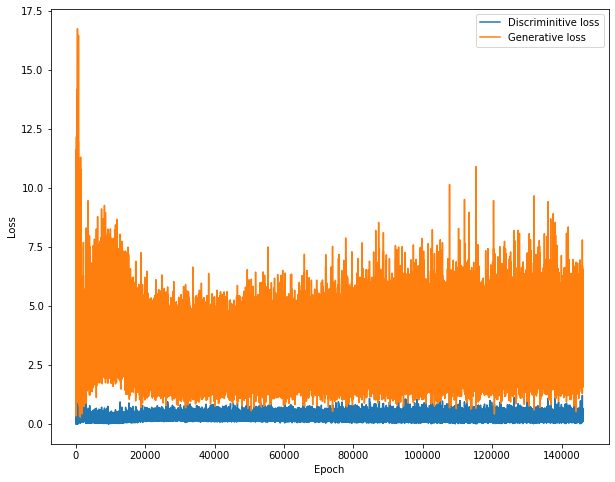

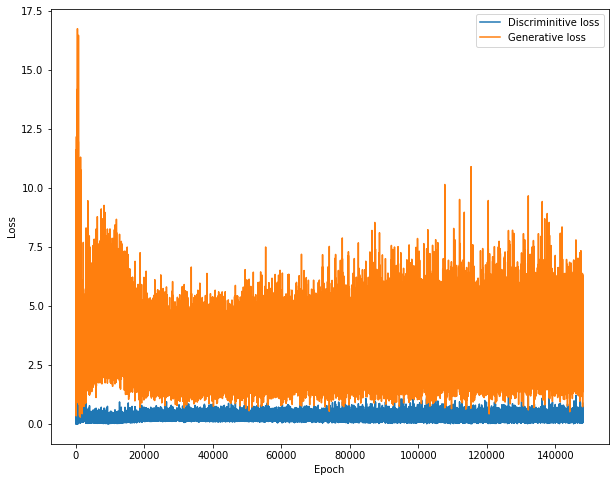

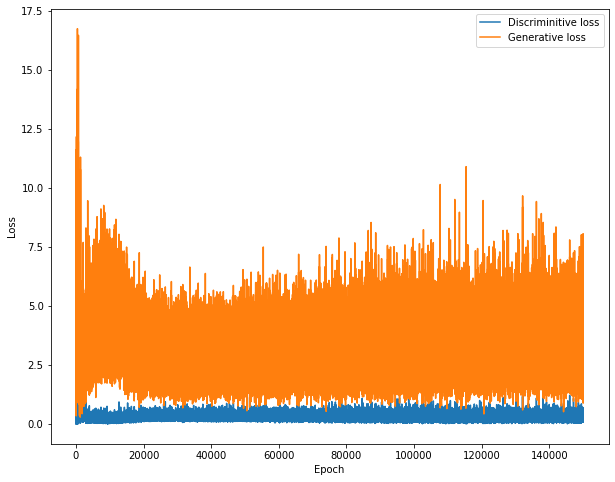

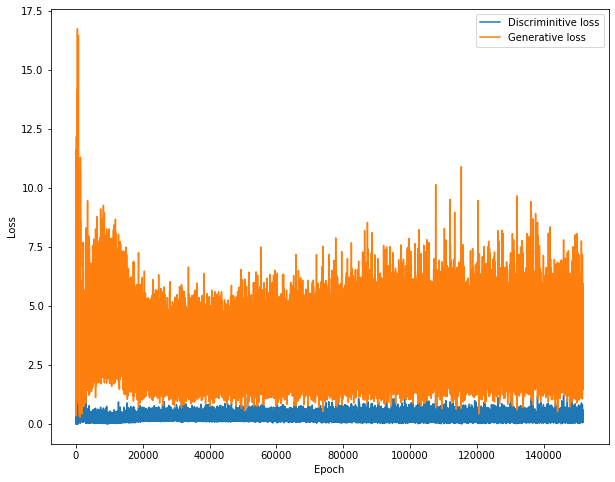

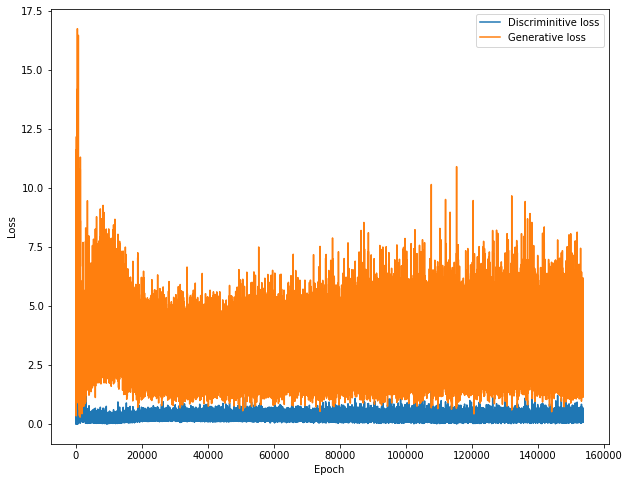

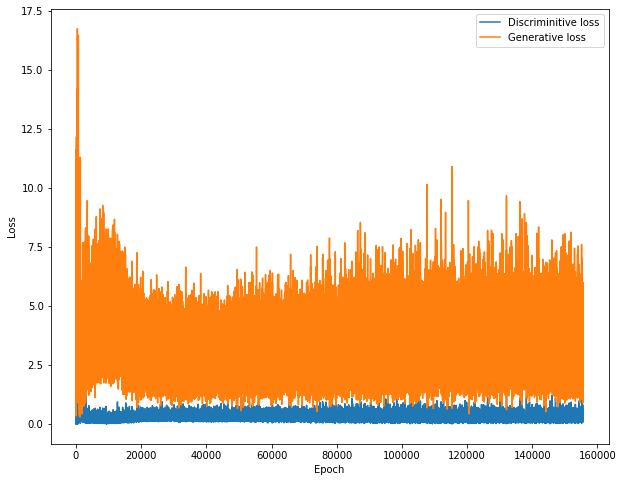

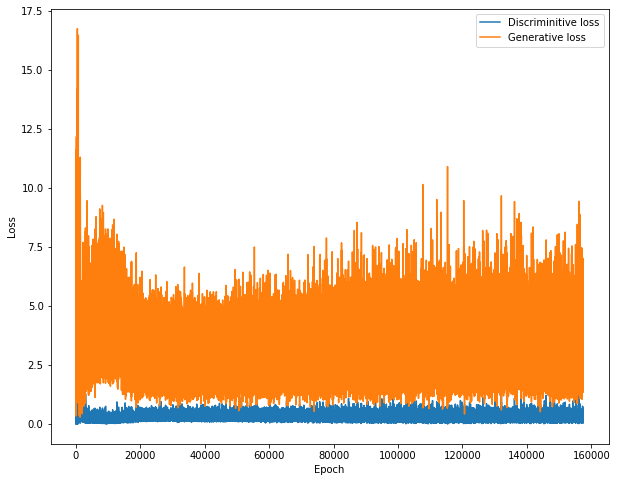

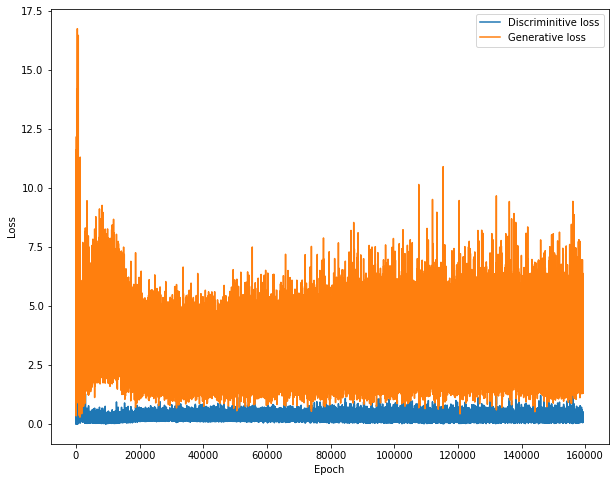

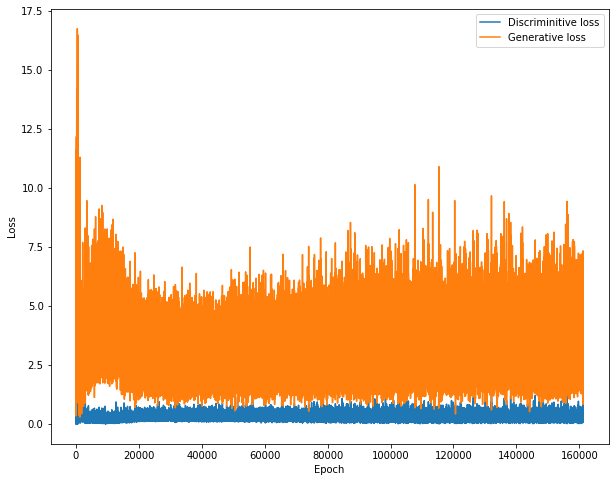

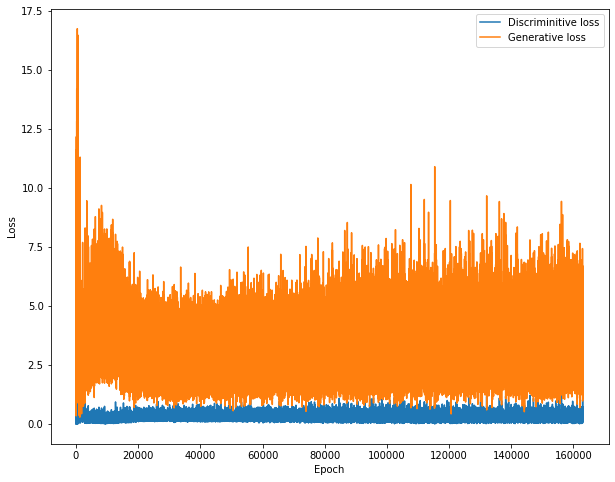

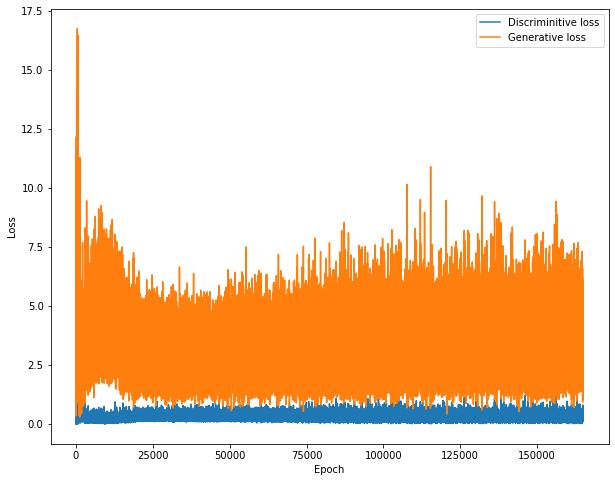

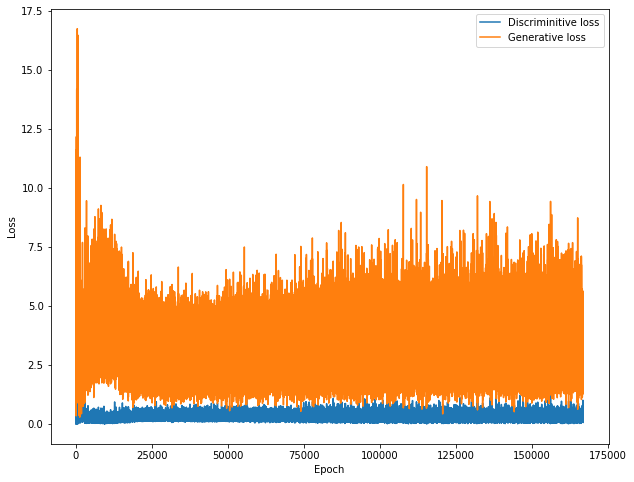

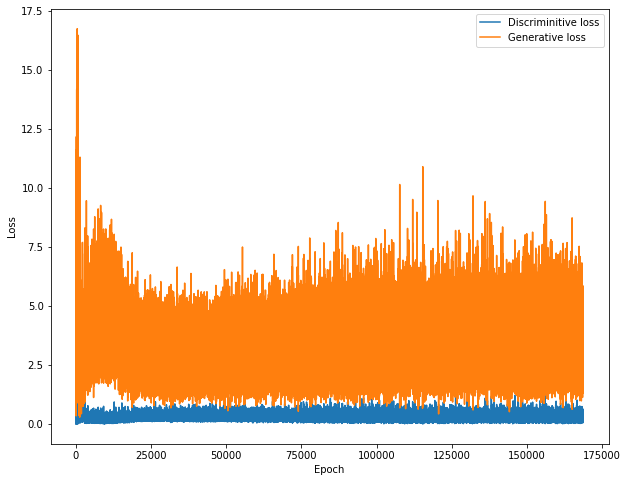

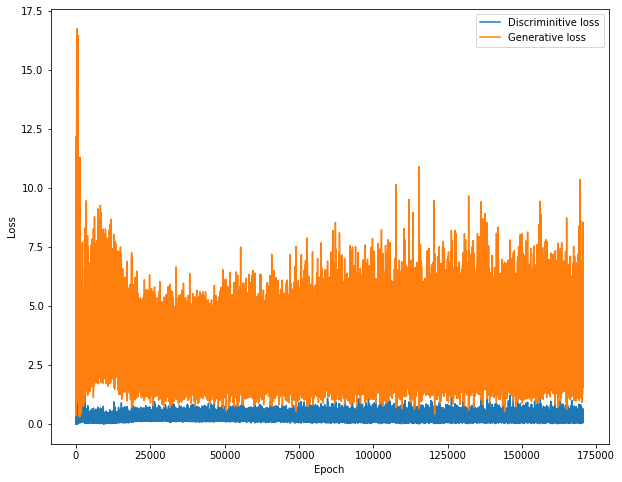

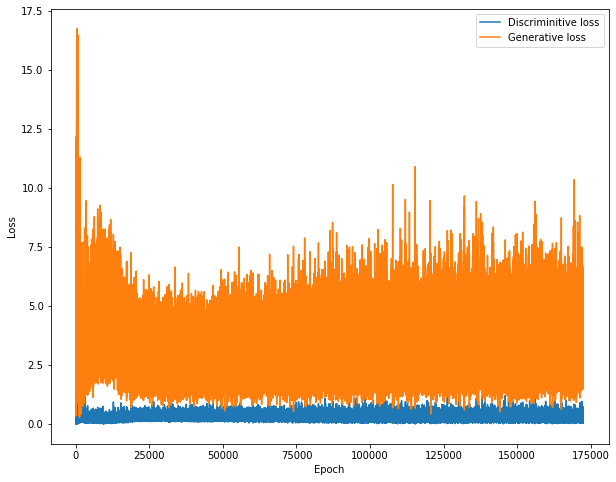

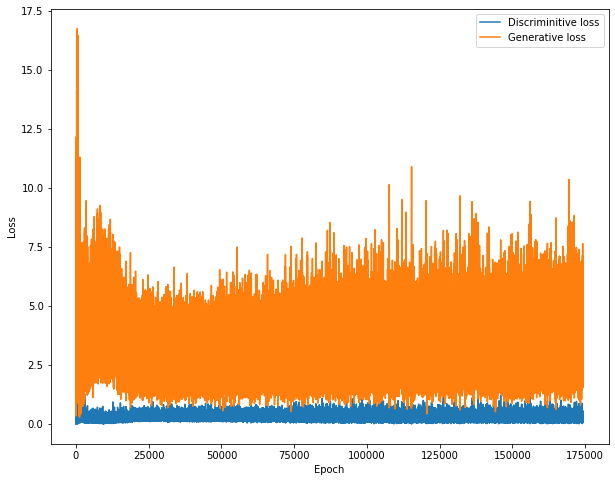

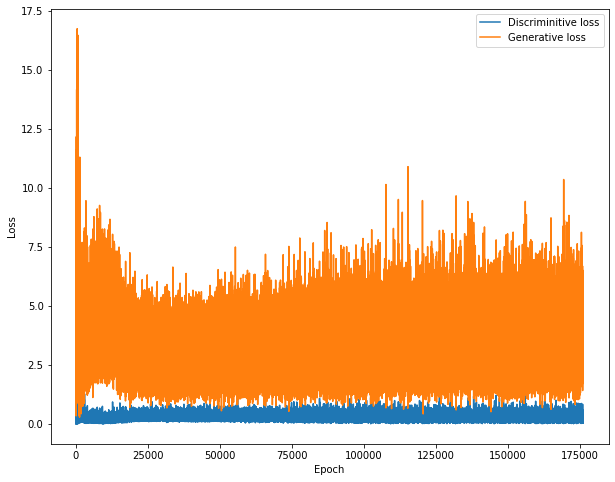

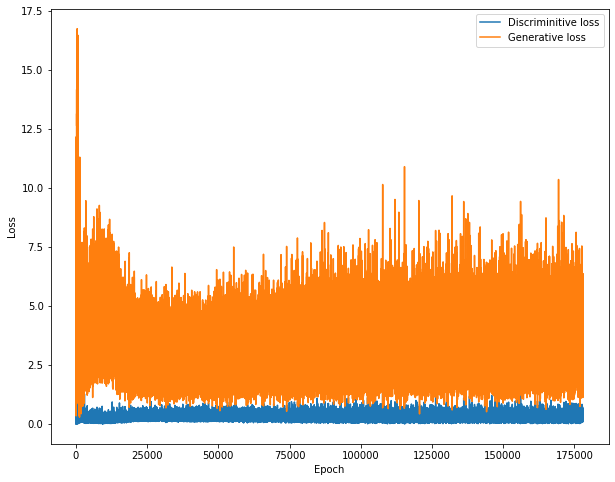

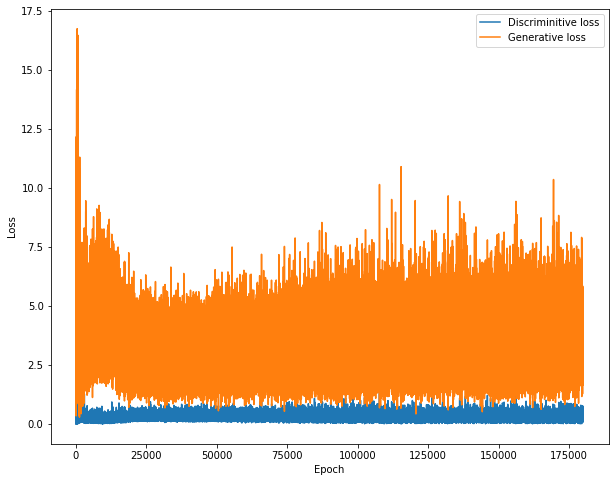

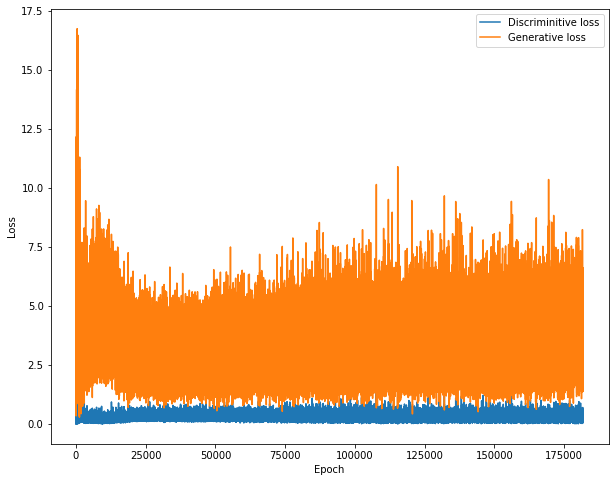

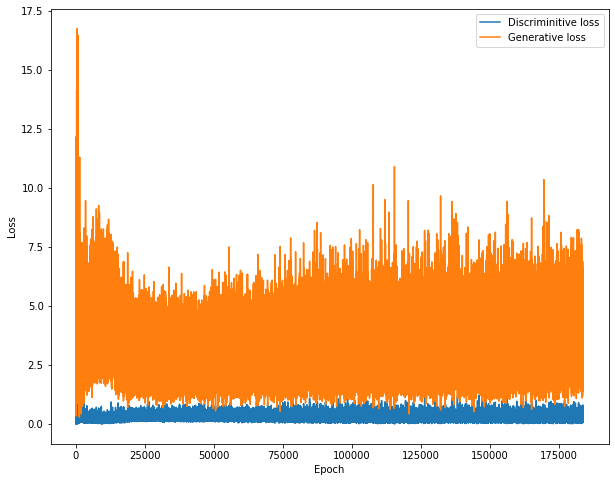

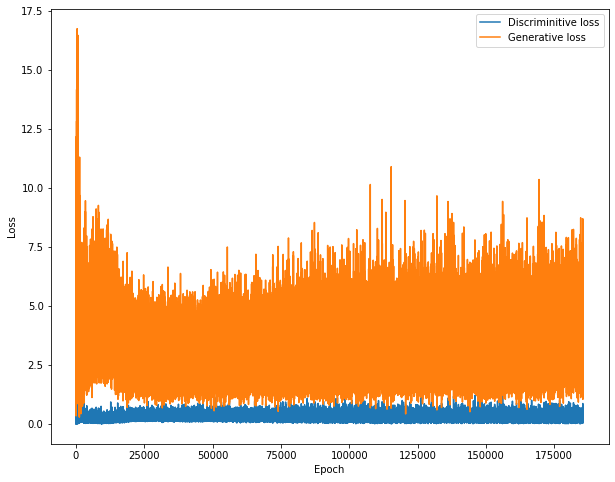

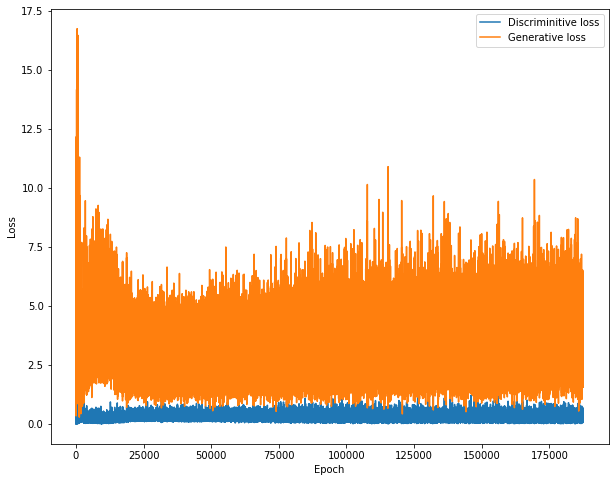

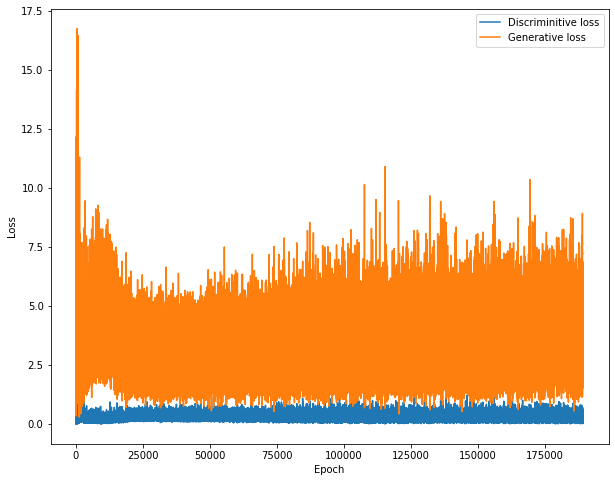

In [ ]:
dataset = create_batch(x_dataset)

train(generator, discriminator, gan, dataset, latent_dim = latent_dim, epochs = 100, batch_size = 32)

1/1 [==============================] - 0s 16ms/step


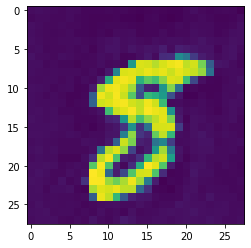

In [ ]:
noise = tf.random.normal(shape = [1, latent_dim])
generated_image = generator.predict(noise)

plt.imshow(generated_image.reshape(28, 28))

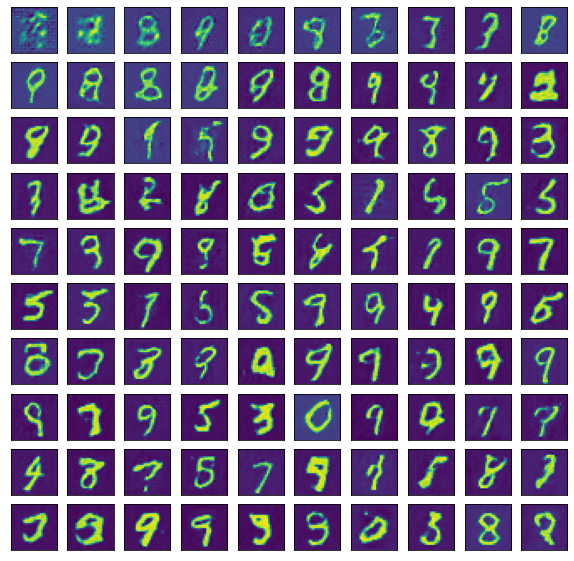

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(progress[i].reshape(28, 28))
plt.show()

1/1 [==============================] - 0s 15ms/step


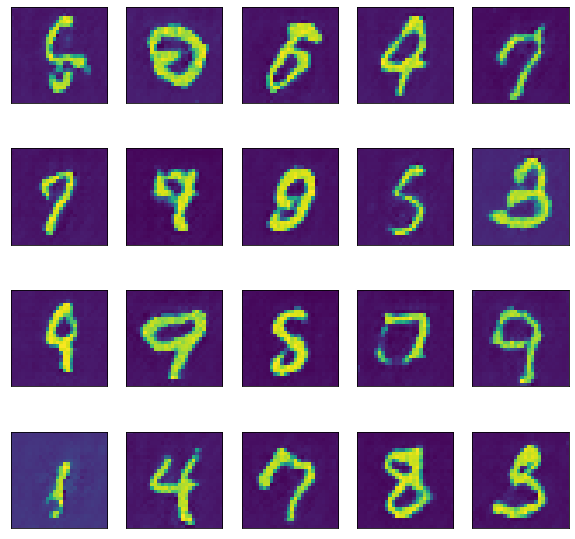

In [ ]:
plt.figure(figsize = (10, 10))
for i in range(20):
  plt.subplot(4, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  noise = tf.random.normal(shape = [1, latent_dim])
  generated_image = generator.predict(noise)
  plt.imshow(generated_image.reshape(28, 28))


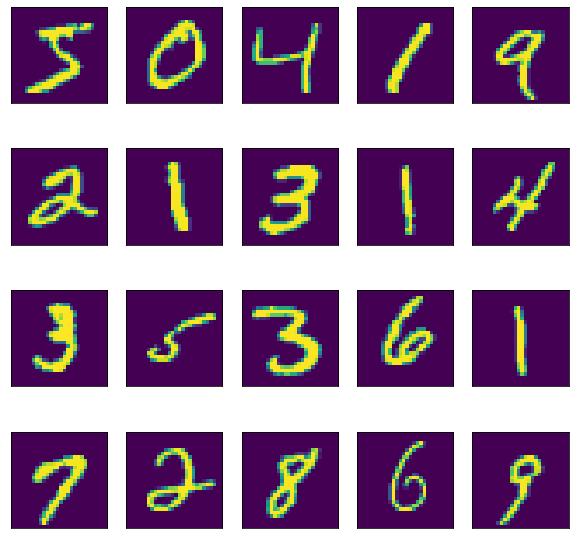

In [ ]:
plt.figure(figsize = (10, 10))

for i in range(20):
  plt.subplot(4, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_dataset[i].reshape(28, 28))